In [1]:
# Wczytanie bibliotek

In [2]:
# !pip install contractions
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# !pip install pyLDAvis
# !pip install textblob
# !pip install wordcloud

import pandas as pd
import numpy as np
import re
import string
import nltk
import string
import contractions
import pickle
import pyLDAvis.sklearn

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
from string import digits


import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Dane pochodzą z https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download 
# Zestaw ten składa się z recenzji produktów spożywczych z Amazon. 
# Dane obejmują okres ponad 10 lat.
# Recenzje obejmują informacje o produktach i użytkownikach, oceny oraz receznję w postaci zwykłego tekstu.
# Zawiera również recenzję ze wszystkich innych kategorii Amazon

In [4]:
# Wczytywanie danych

In [5]:
df = pd.read_csv('Reviews.csv', sep=',', nrows = 10000);
df.reset_index(drop=True, inplace=True);
print(df)

         Id   ProductId          UserId                      ProfileName  \
0         1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1         2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2         3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3         4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4         5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...     ...         ...             ...                              ...   
9995   9996  B000P41A28  A3A63RACXR1XIL            A. Boodhoo "deaddodo"   
9996   9997  B000P41A28    A5VVRGL8JA7R                             Adam   
9997   9998  B000P41A28  A2TGDTJ8YCU6PD                          geena77   
9998   9999  B000P41A28   AUV4GIZZE693O              Susan Coe "sueysis"   
9999  10000  B000P41A28   A82WIMR4RSVLI                       Emrose mom   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0             

In [6]:
#  Sprawdzamy czy nie ma jakiś brakujących danych

In [7]:
for col in df.columns:
    print(col, df[col].isnull().sum())
# Brakujące dane znajdują sie tylko w kolumnach ProfileName oraz Summary które nas nie interesują.

Id 0
ProductId 0
UserId 0
ProfileName 0
HelpfulnessNumerator 0
HelpfulnessDenominator 0
Score 0
Time 0
Summary 0
Text 0


In [8]:
# Wybranie odpowidnich kolumn

In [9]:
# to_drop = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary']
# df.drop(to_drop, inplace = True, axis = 1)

rws = df.loc[:, ['Score', 'Text']];
print(rws)

      Score                                               Text
0         5  I have bought several of the Vitality canned d...
1         1  Product arrived labeled as Jumbo Salted Peanut...
2         4  This is a confection that has been around a fe...
3         2  If you are looking for the secret ingredient i...
4         5  Great taffy at a great price.  There was a wid...
...     ...                                                ...
9995      1  we switched from the advance similac to the or...
9996      5  Like the bad reviews say, the organic formula ...
9997      5  I wanted to solely breastfeed but was unable t...
9998      5  i love the fact that i can get this delieved t...
9999      4  We have a 7 week old... He had gas and constip...

[10000 rows x 2 columns]


In [10]:
# Czyszczenie tekstu

In [11]:
punc = string.punctuation;
stop_words = set(stopwords.words('english'));

# Angielskie skróty rozszerzone
rws['no_contract'] = rws['Text'].apply(lambda x: [contractions.fix(word) for word in x.split()]);
rws['text_str'] = [' '.join(map(str, l)) for l in rws['no_contract']];

# Usuniete '...'
rws['...'] = rws['text_str'].apply(lambda x: [word.replace("...", "") for word in x.split()]);

# Usunięte html
rws['non_html'] = rws['...'].apply(lambda x: [re.sub(r'http\S+', '', word) for word in x]);

# Usunięta interpunkcja
rws['non_dots'] = rws['non_html'].apply(lambda x: [re.sub(r"\b\d+\b", "", word) for word in x]);
rws['non_other'] = rws['non_dots'].apply(lambda x: [re.sub(r'[^\w]', ' ', word) for word in x]);

# Małe litery
rws['lower'] = rws['non_other'].apply(lambda x: [word.lower() for word in x]);

# Usunięcię interpunkcji
rws['no_punc'] = rws['lower'].apply(lambda x: [word for word in x if word not in punc]);

# Usunięcie StopWords
rws['stopwords_removed'] = rws['no_punc'].apply(lambda x: [word for word in x if word not in stop_words]);

# Usunięcie wszystkich innych specjalnych znaków
rws['final'] = rws['stopwords_removed'].apply(lambda x: [re.sub('[^A-Za-z0-9]+', '', word) for word in x]);

train_data = rws['final']
print(rws['final'])

0       [bought, several, vitality, canned, dog, food,...
1       [product, arrived, labeled, jumbo, salted, pea...
2       [confection, around, centuries, light, pillowy...
3       [looking, secret, ingredient, robitussin, beli...
4       [great, taffy, great, price, wide, assortment,...
                              ...                        
9995    [switched, advance, similac, organic, product,...
9996    [like, bad, reviews, say, organic, formula, co...
9997    [wanted, solely, breastfeed, unable, keep, sup...
9998    [love, fact, get, delieved, house, delievy, ch...
9999    [week, old, gas, constipation, problems, first...
Name: final, Length: 10000, dtype: object


In [12]:
# Stemmeing

In [13]:
stemmer = SnowballStemmer("english")

rws['stemmed'] = rws['final'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
print(rws['stemmed'])


0       [bought, sever, vital, can, dog, food, product...
1       [product, arriv, label, jumbo, salt, peanutsth...
2       [confect, around, centuri, light, pillowi, cit...
3       [look, secret, ingredi, robitussin, believ, fo...
4       [great, taffi, great, price, wide, assort, yum...
                              ...                        
9995    [switch, advanc, similac, organ, product, thin...
9996    [like, bad, review, say, organ, formula, const...
9997    [want, sole, breastfe, unabl, keep, supplement...
9998    [love, fact, get, deliev, hous, delievi, charg...
9999    [week, old, gas, constip, problem, first, week...
Name: stemmed, Length: 10000, dtype: object


In [14]:
# Lematyzacja

In [15]:
rws['pos_tags'] = rws['stemmed'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
rws['wordnet_pos'] = rws['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()
rws['lemmatized'] = rws['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
lemmatized = rws.lemmatized
print(lemmatized)

0       [buy, sever, vital, can, dog, food, product, f...
1       [product, arriv, label, jumbo, salt, peanutsth...
2       [confect, around, centuri, light, pillowi, cit...
3       [look, secret, ingredi, robitussin, believ, fi...
4       [great, taffi, great, price, wide, assort, yum...
                              ...                        
9995    [switch, advanc, similac, organ, product, thin...
9996    [like, bad, review, say, organ, formula, const...
9997    [want, sole, breastfe, unabl, keep, supplement...
9998    [love, fact, get, deliev, hous, delievi, charg...
9999    [week, old, gas, constip, problem, first, week...
Name: lemmatized, Length: 10000, dtype: object


In [16]:
# Wybieramy naszą ocenę oraz oczyszczoną kolumnę
df = rws[['Score', 'lemmatized']]
print(df)

      Score                                         lemmatized
0         5  [buy, sever, vital, can, dog, food, product, f...
1         1  [product, arriv, label, jumbo, salt, peanutsth...
2         4  [confect, around, centuri, light, pillowi, cit...
3         2  [look, secret, ingredi, robitussin, believ, fi...
4         5  [great, taffi, great, price, wide, assort, yum...
...     ...                                                ...
9995      1  [switch, advanc, similac, organ, product, thin...
9996      5  [like, bad, review, say, organ, formula, const...
9997      5  [want, sole, breastfe, unabl, keep, supplement...
9998      5  [love, fact, get, deliev, hous, delievi, charg...
9999      4  [week, old, gas, constip, problem, first, week...

[10000 rows x 2 columns]


In [17]:
# Analiza nastrojów

# -1 = bardzo negatywnie
# 1 = bardzo pozytywnie

In [18]:
df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemmatized']]
print(df)

      Score                                         lemmatized  \
0         5  [buy, sever, vital, can, dog, food, product, f...   
1         1  [product, arriv, label, jumbo, salt, peanutsth...   
2         4  [confect, around, centuri, light, pillowi, cit...   
3         2  [look, secret, ingredi, robitussin, believ, fi...   
4         5  [great, taffi, great, price, wide, assort, yum...   
...     ...                                                ...   
9995      1  [switch, advanc, similac, organ, product, thin...   
9996      5  [like, bad, review, say, organ, formula, const...   
9997      5  [want, sole, breastfe, unabl, keep, supplement...   
9998      5  [love, fact, get, deliev, hous, delievi, charg...   
9999      4  [week, old, gas, constip, problem, first, week...   

                                              lemma_str  
0     buy sever vital can dog food product find good...  
1     product arriv label jumbo salt peanutsth peanu...  
2     confect around centuri ligh

C:\Users\mateu\AppData\Local\Temp/ipykernel_14984/1647747786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemmatized']]


In [19]:
df['sentiment'] = df['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_data = df.drop(columns = ['lemmatized', 'sentiment'])
print(df)
# print(df_data)

      Score                                         lemmatized  \
0         5  [buy, sever, vital, can, dog, food, product, f...   
1         1  [product, arriv, label, jumbo, salt, peanutsth...   
2         4  [confect, around, centuri, light, pillowi, cit...   
3         2  [look, secret, ingredi, robitussin, believ, fi...   
4         5  [great, taffi, great, price, wide, assort, yum...   
...     ...                                                ...   
9995      1  [switch, advanc, similac, organ, product, thin...   
9996      5  [like, bad, review, say, organ, formula, const...   
9997      5  [want, sole, breastfe, unabl, keep, supplement...   
9998      5  [love, fact, get, deliev, hous, delievi, charg...   
9999      4  [week, old, gas, constip, problem, first, week...   

                                              lemma_str  sentiment  
0     buy sever vital can dog food product find good...   0.500000  
1     product arriv label jumbo salt peanutsth peanu...   0.083333  


C:\Users\mateu\AppData\Local\Temp/ipykernel_14984/896638914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)


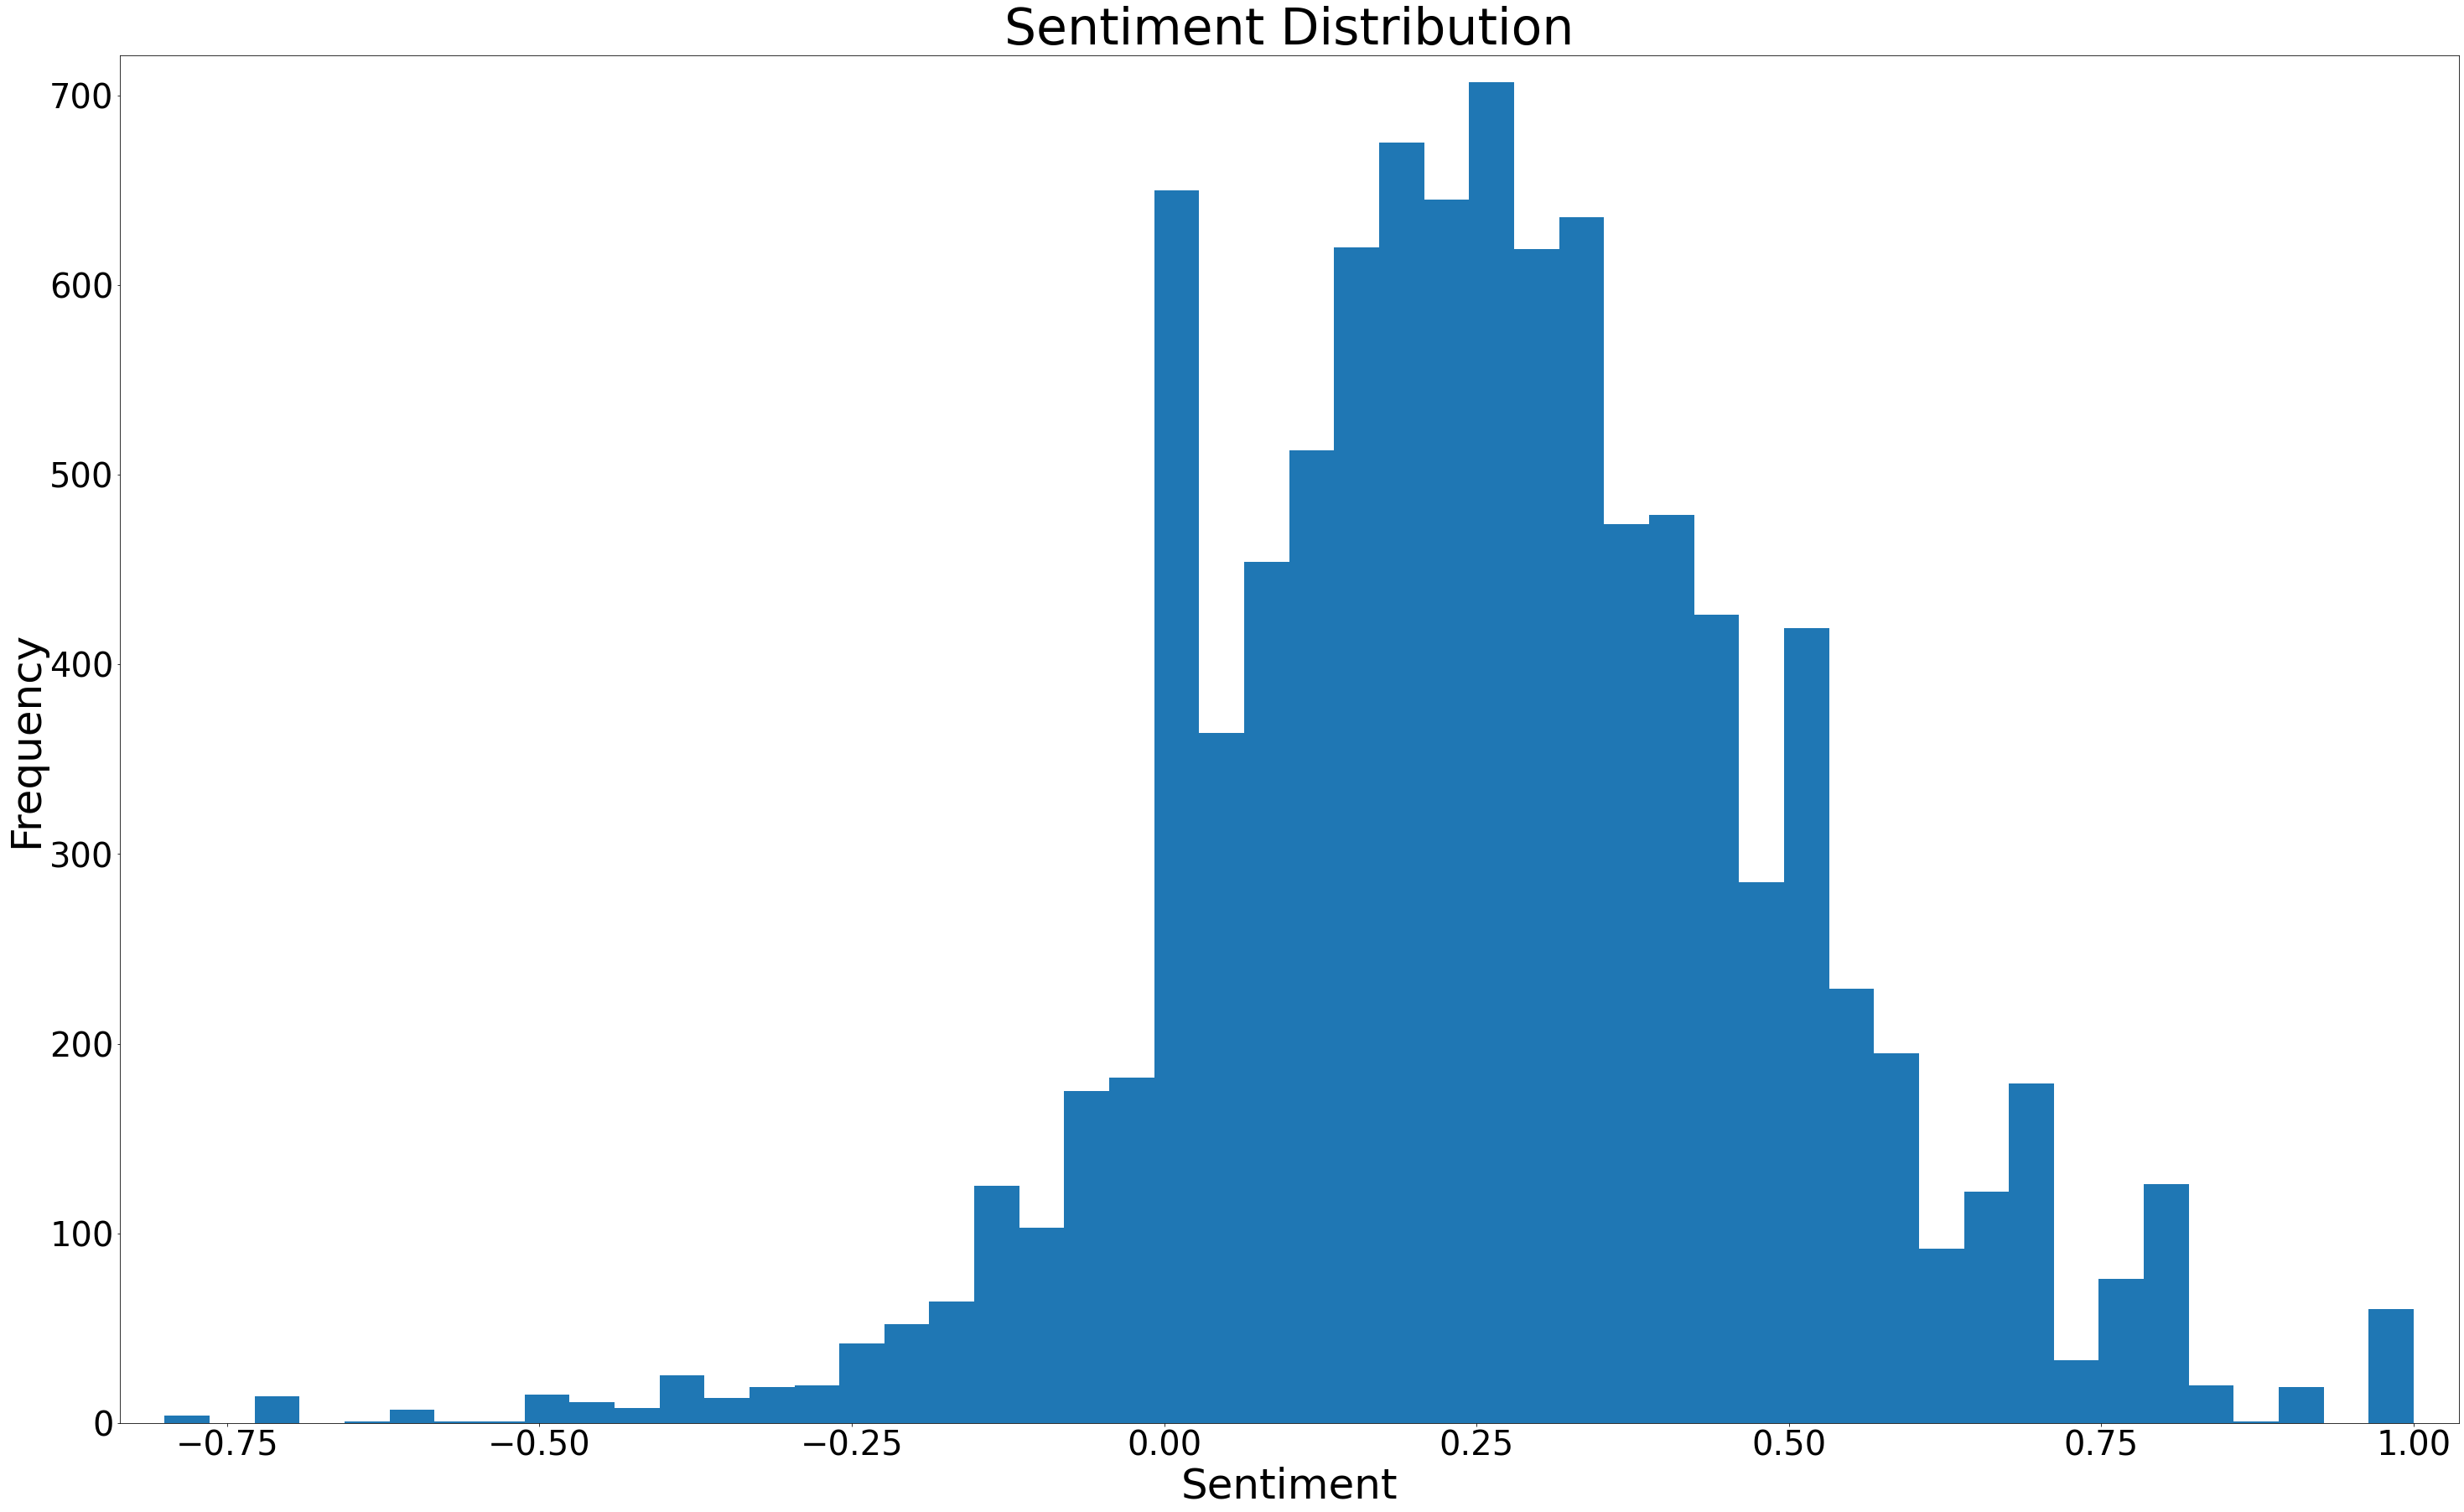

In [20]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

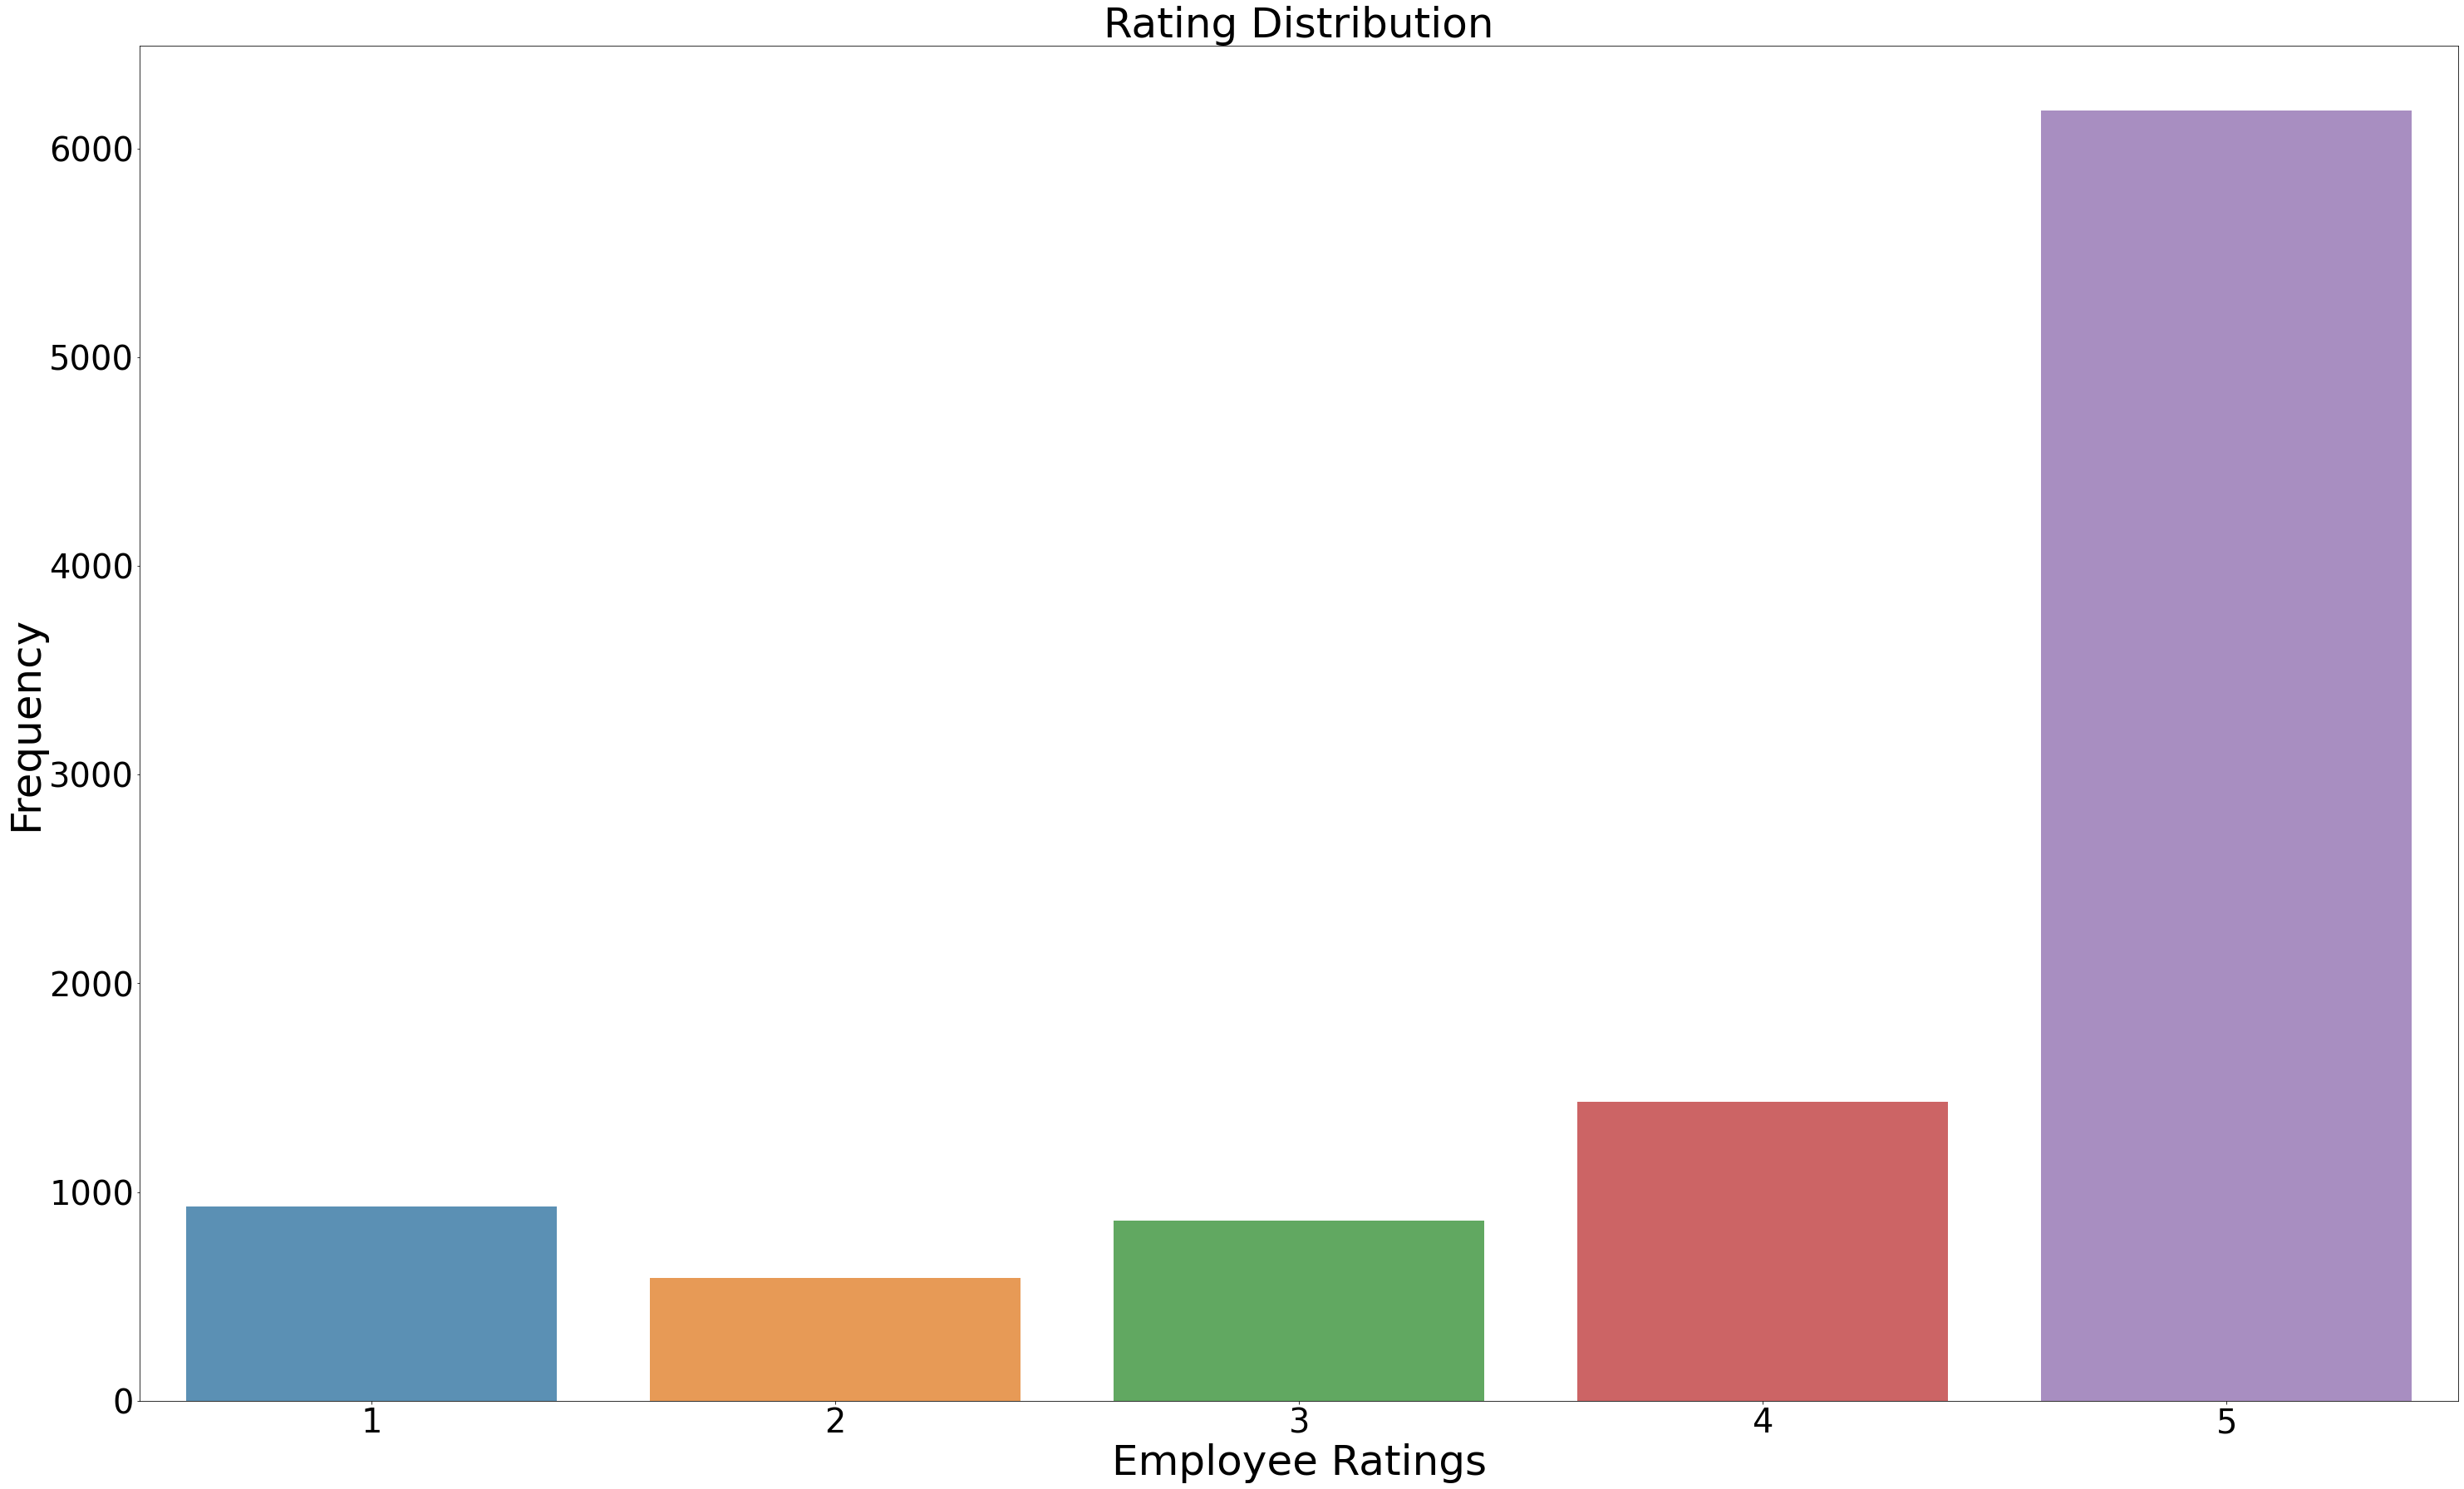

In [21]:
x_score = df.Score.value_counts()
y_score = x_score.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_score.index, x_score.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Employee Ratings', fontsize=50)
plt.xticks(fontsize=40)

<AxesSubplot:title={'center':'Percentage of Score'}, ylabel='Score'>

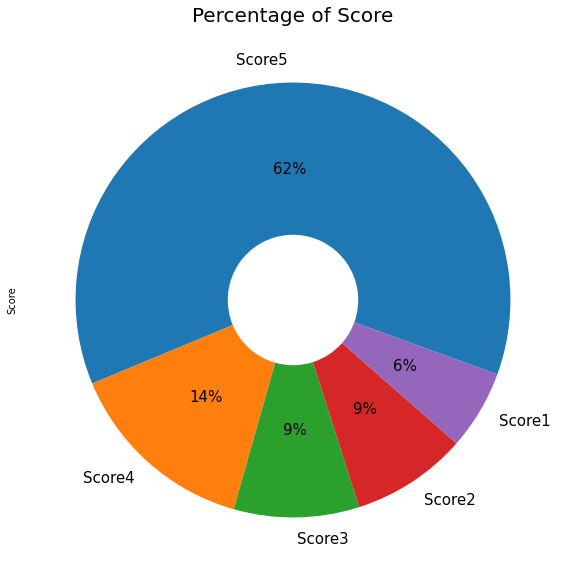

In [22]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Score', fontsize=20)
df.Score.value_counts().plot(kind='pie', labels=['Score5', 'Score4', 'Score3', 'Score2', 'Score1'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

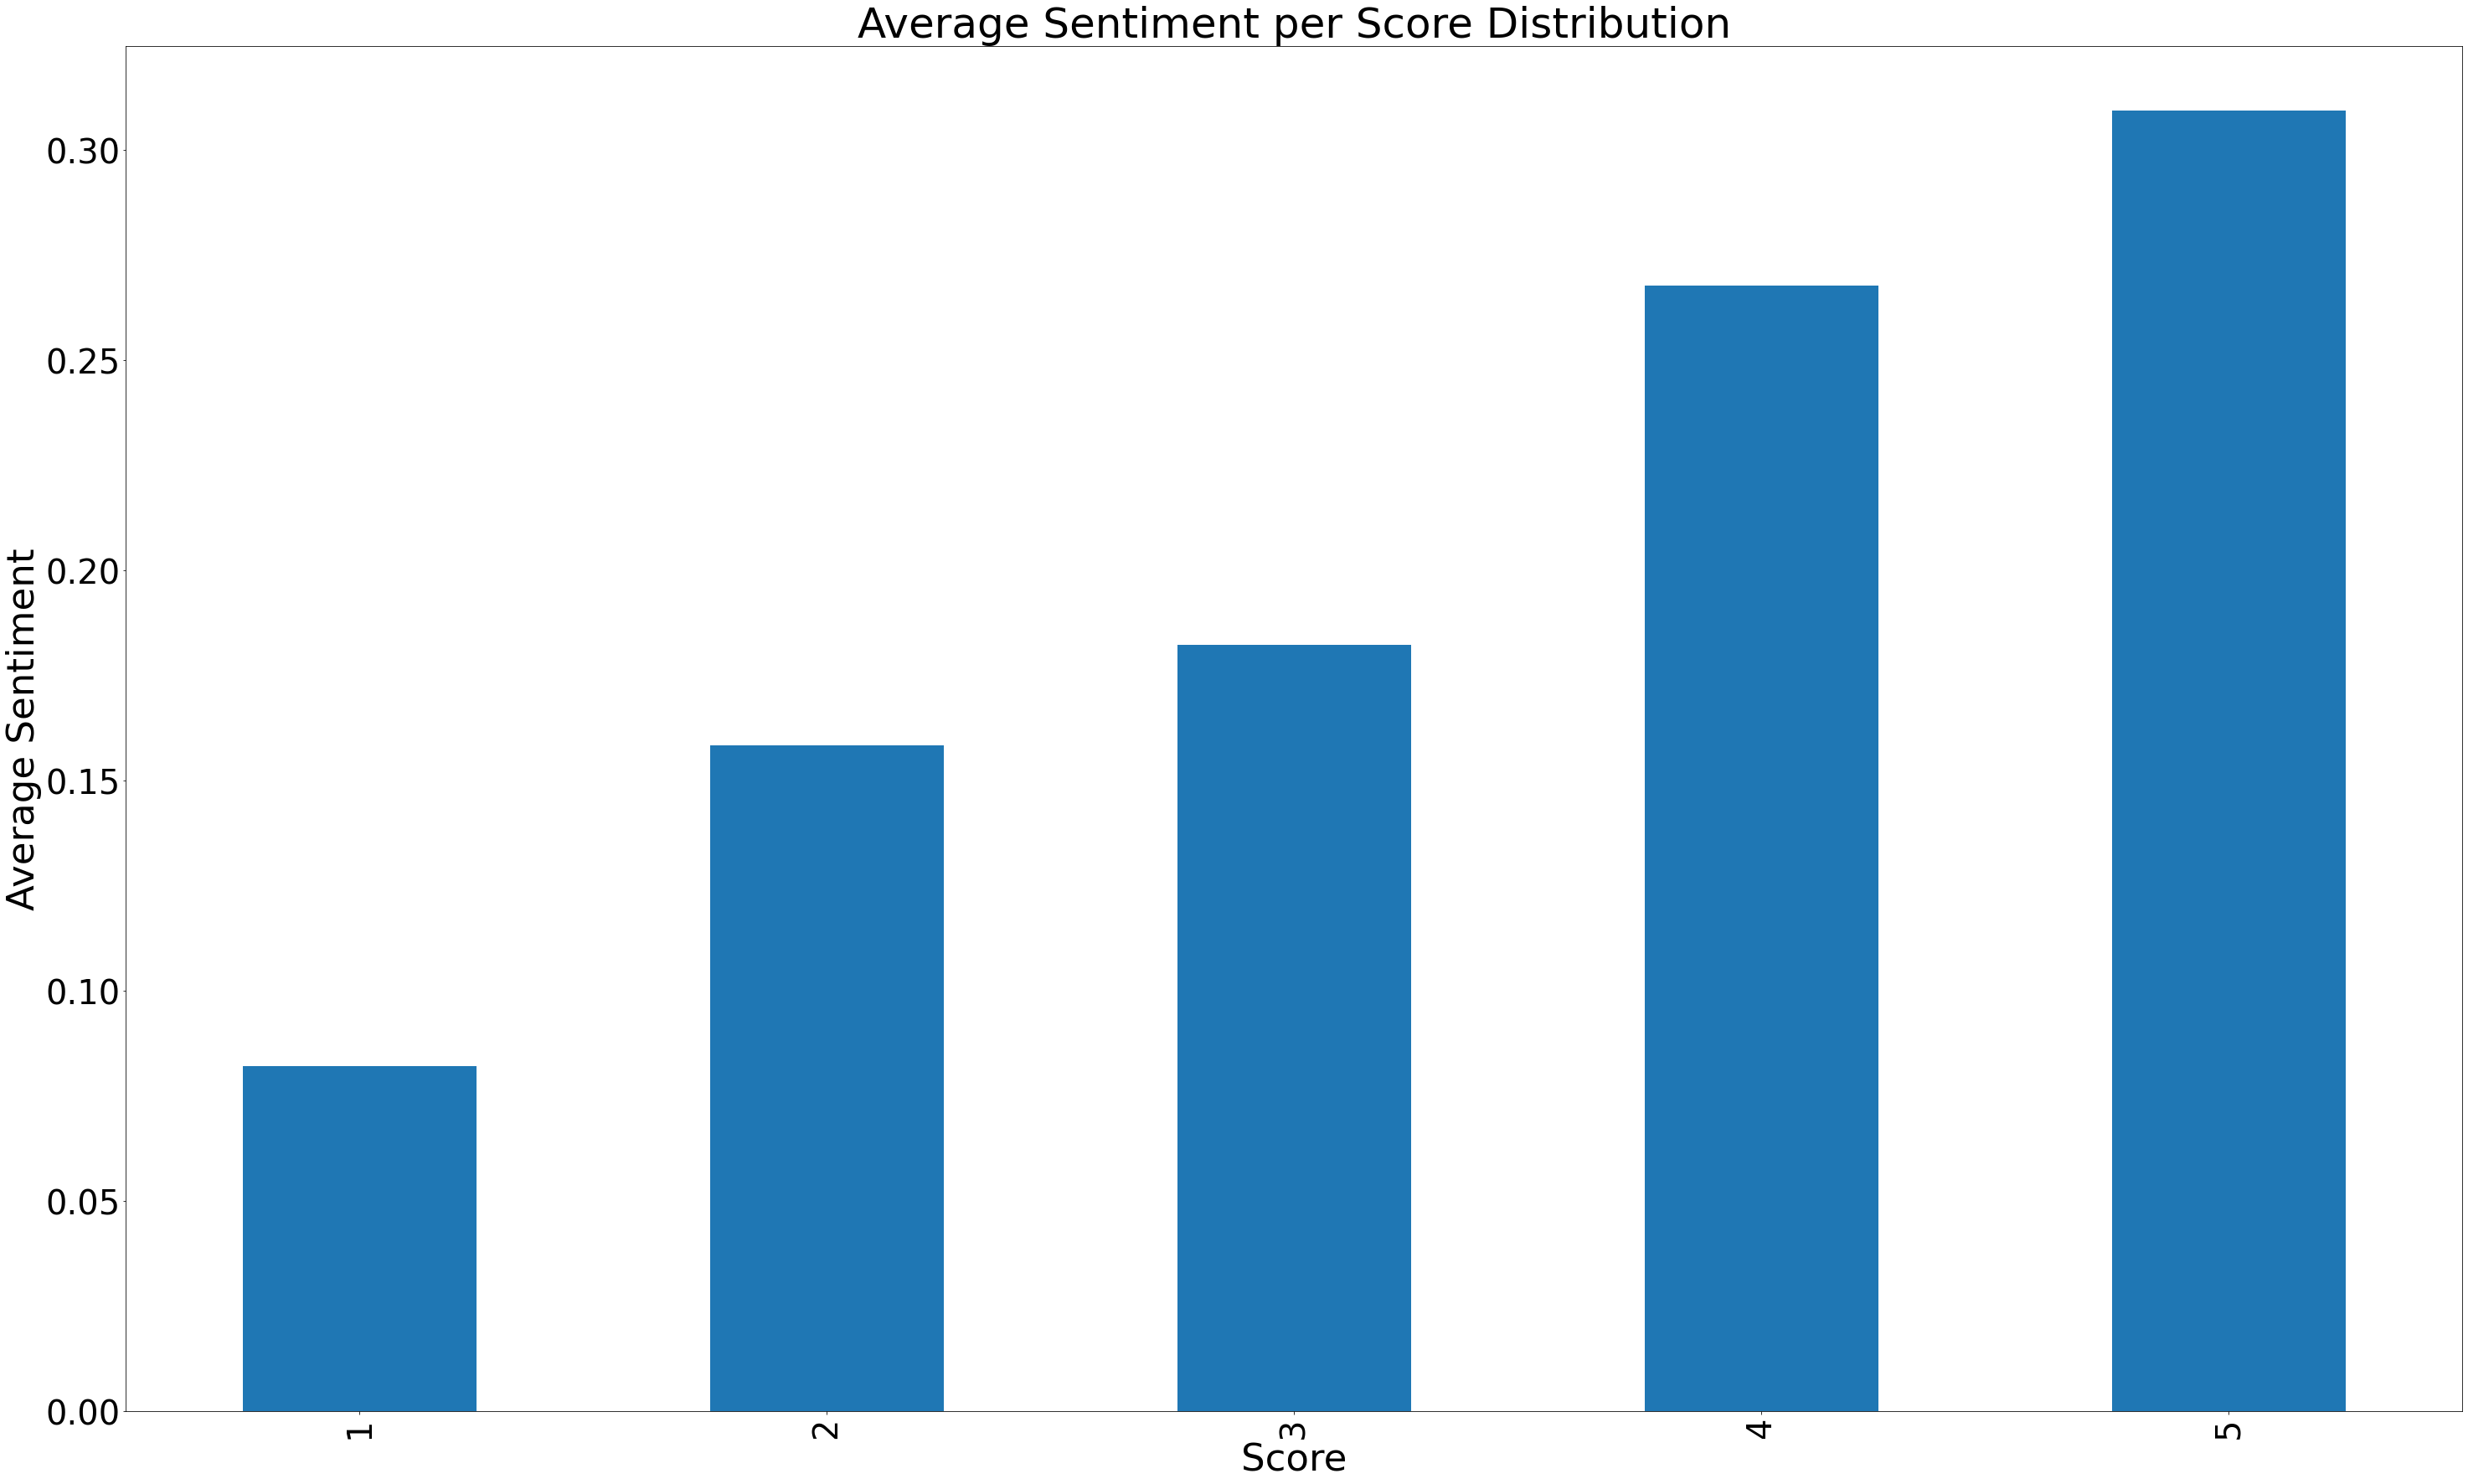

In [23]:
polarity_avg = df.groupby('Score')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Score', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Score Distribution', fontsize=50)
plt.show()

In [24]:
# Najcześciej wykorzystywane słowa, chmura słów
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000

In [25]:
words = df['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
    
print(allwords)

['buy', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'find', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'good', 'labrador', 'finicki', 'appreci', 'product', 'well', 'most', 'product', 'arriv', 'label', 'jumbo', 'salt', 'peanutsth', 'peanut', 'actual', 'small', 'size', 'unsalt', 'sure', 'error', 'vendor', 'intend', 'repres', 'product', 'jumbo', 'confect', 'around', 'centuri', 'light', 'pillowi', 'citrus', 'gelatin', 'nut', '', 'case', 'filbert', 'cut', 'tini', 'squar', 'liber', 'coat', 'powder', 'sugar', 'tini', 'mouth', 'heaven', 'chewi', 'flavor', 'high', 'recommend', 'yummi', 'treat', 'familiar', 'stori', 'c', 'lewi', 'the', 'lion', 'witch', 'wardrob', '', 'treat', 'seduc', 'edmund', 'sell', 'brother', 'sister', 'witch', 'look', 'secret', 'ingredi', 'robitussin', 'believ', 'find', 'it', 'get', 'addit', 'root', 'beer', 'extract', 'order', 'which', 'good', 'make', 'cherri', 'soda', 'flavor', 'medicin', 'great', 'taffi', 'great', 'price', 'wi

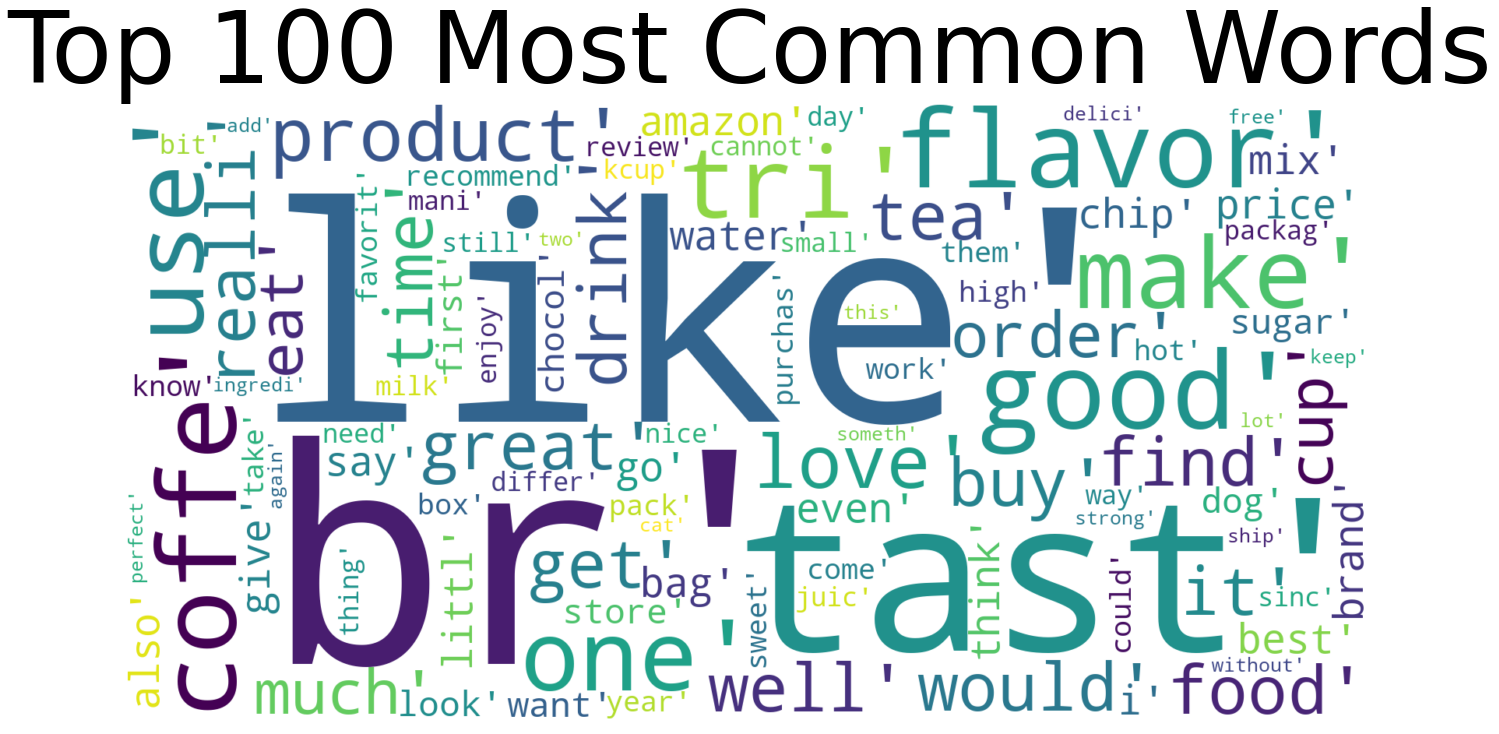

In [26]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

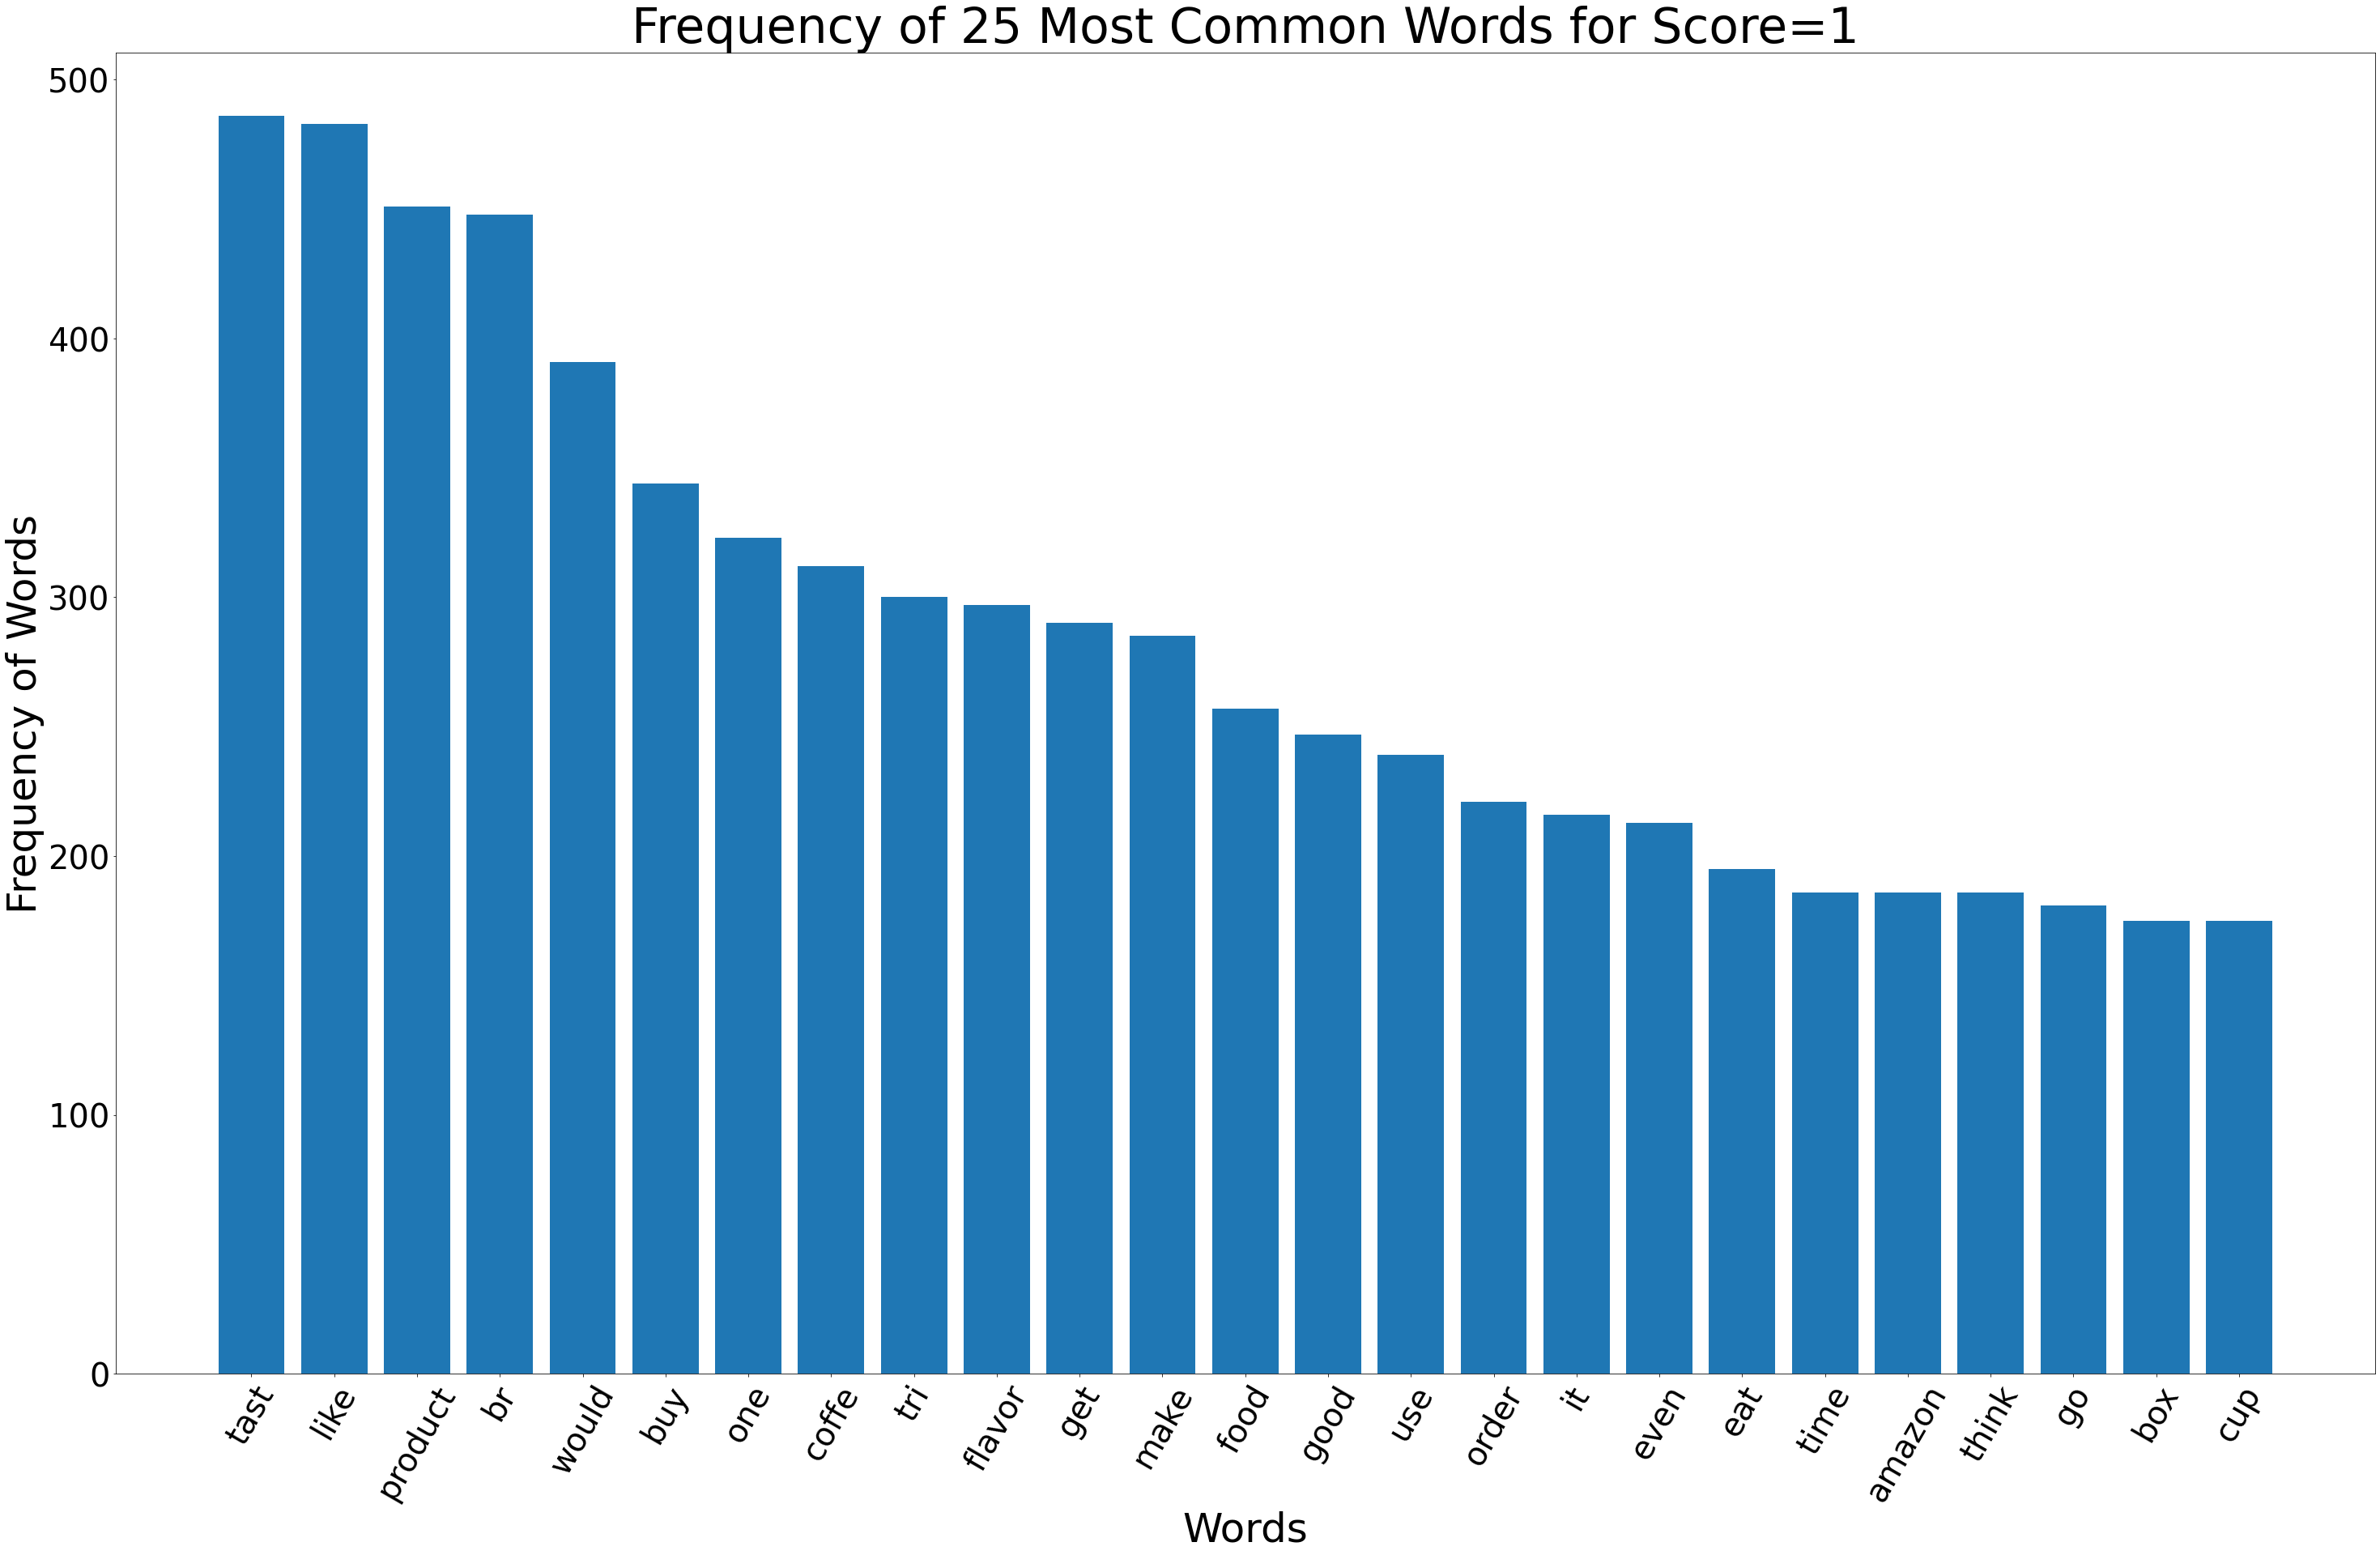

In [27]:
group_by = df.groupby('Score')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Score=1', fontsize=60)
plt.show()

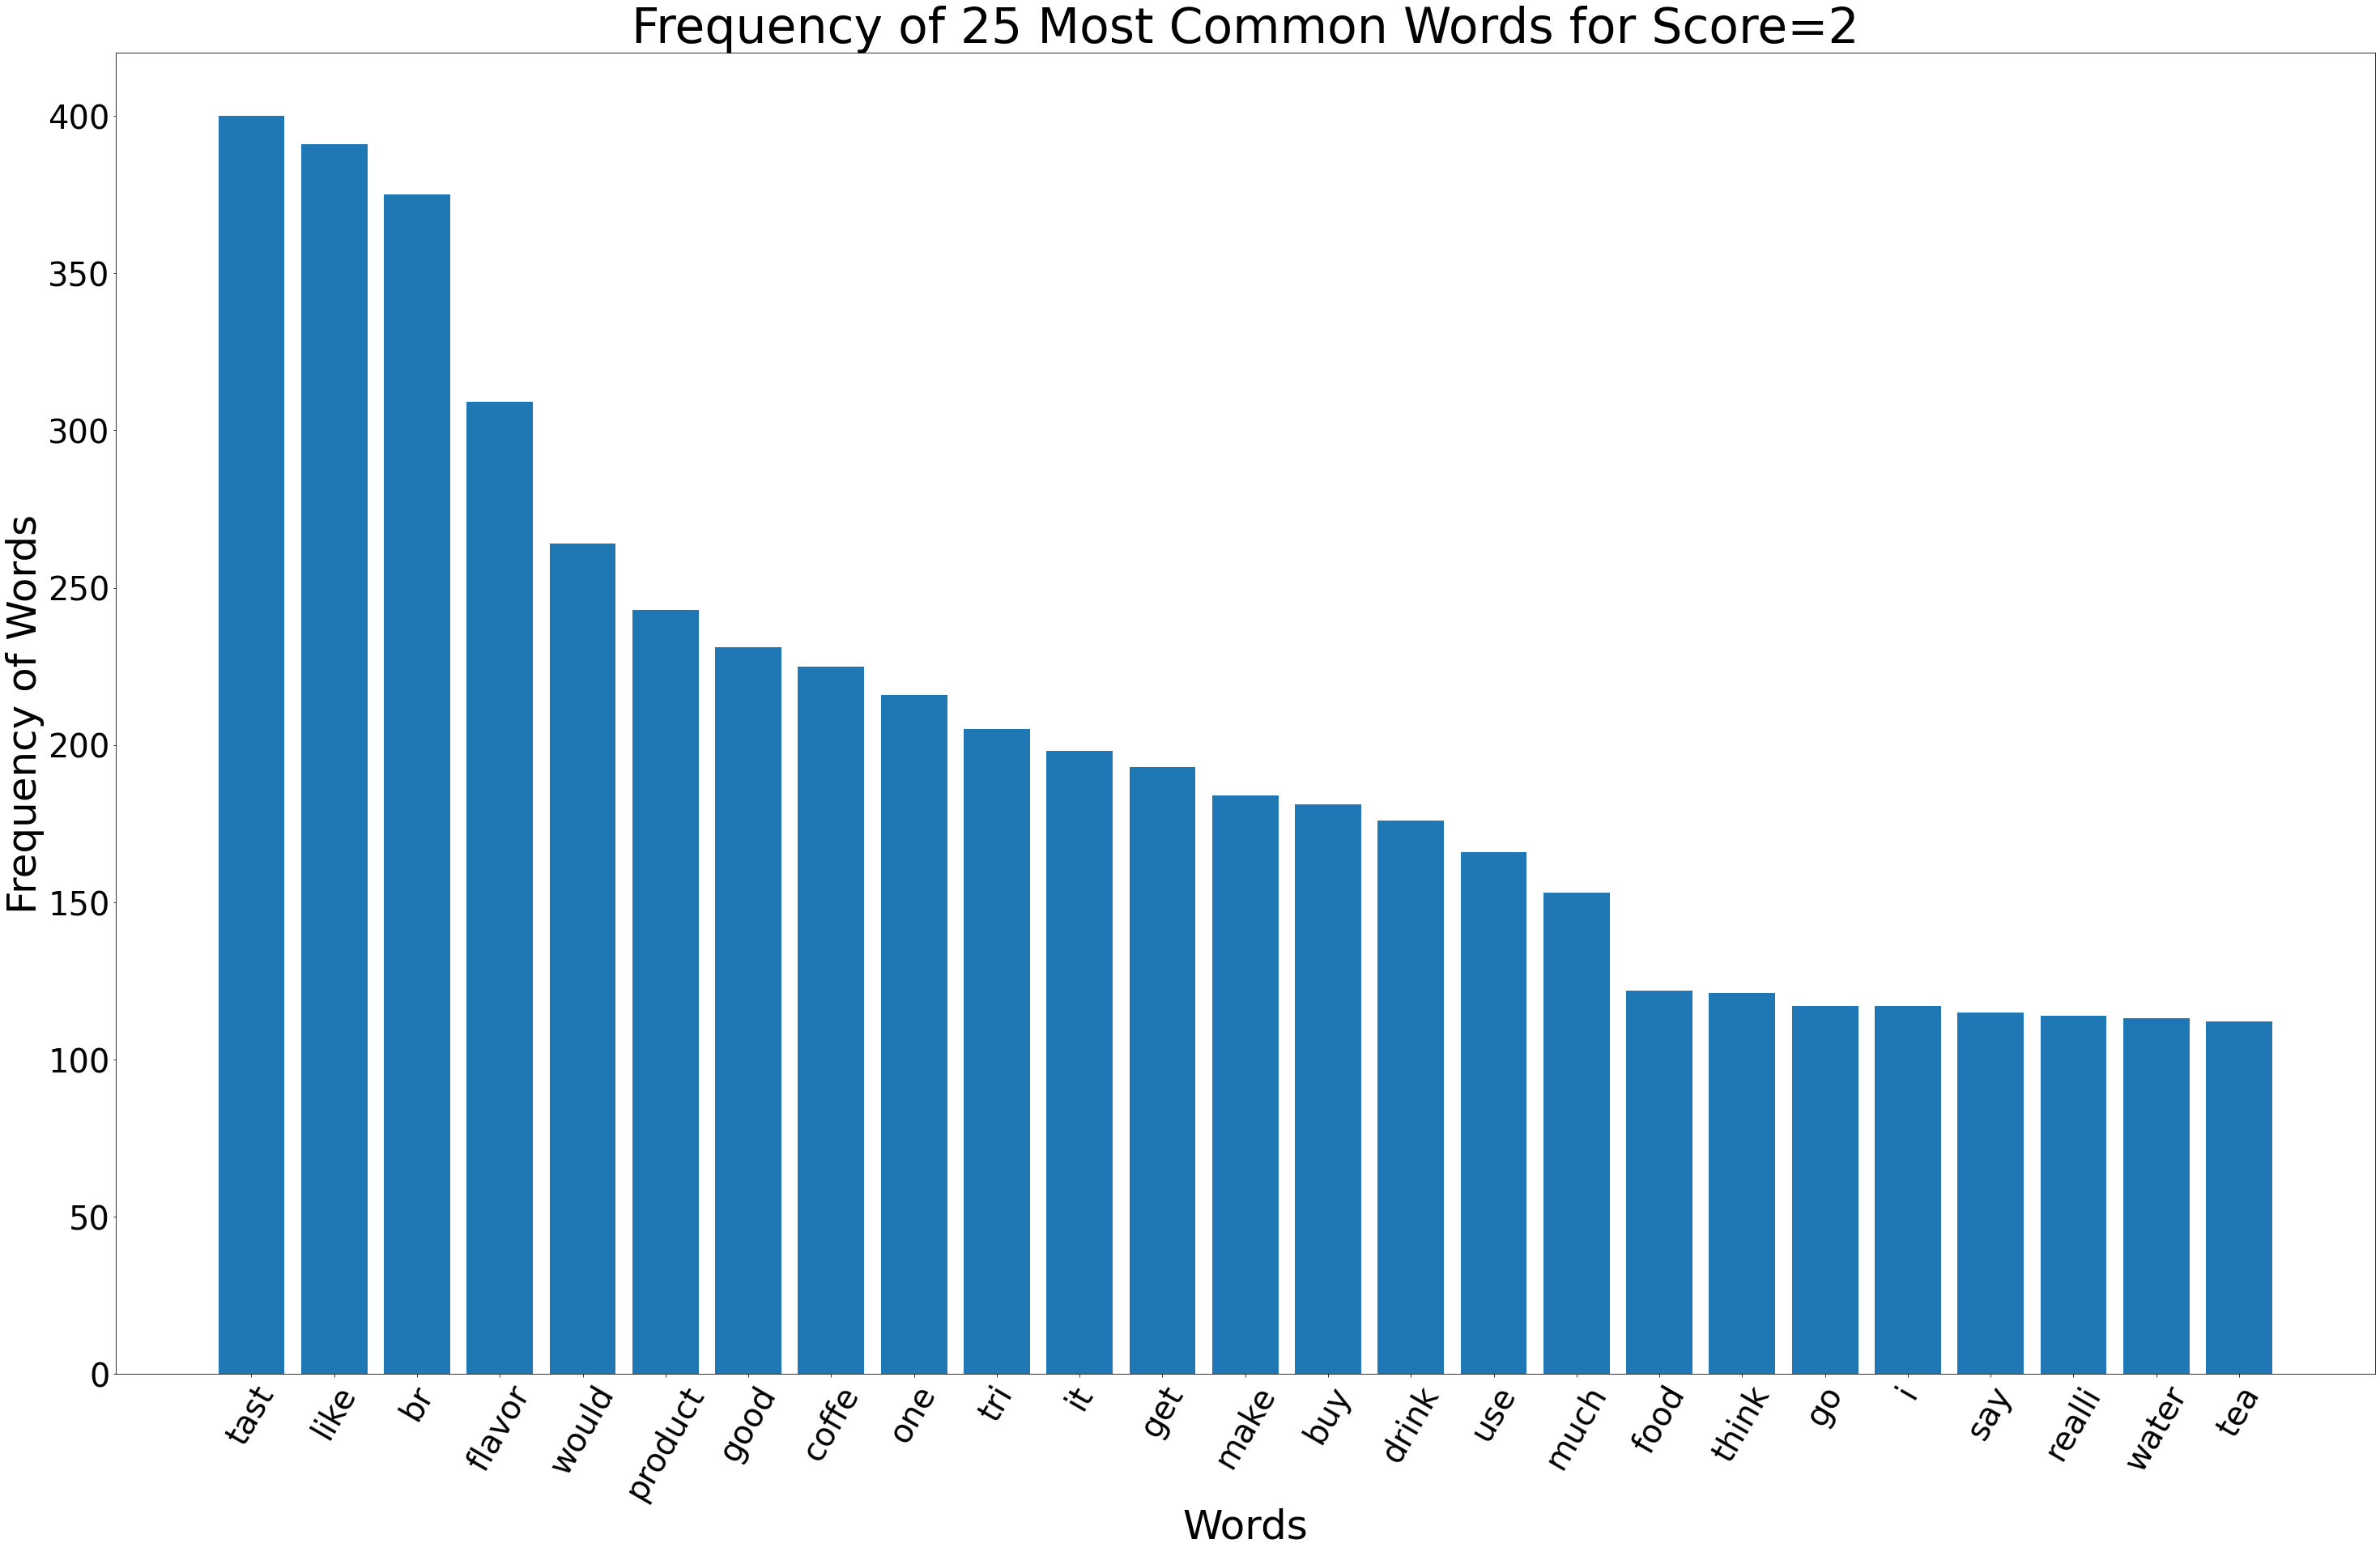

In [28]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(50,30))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Score=2', fontsize=60)
plt.show()

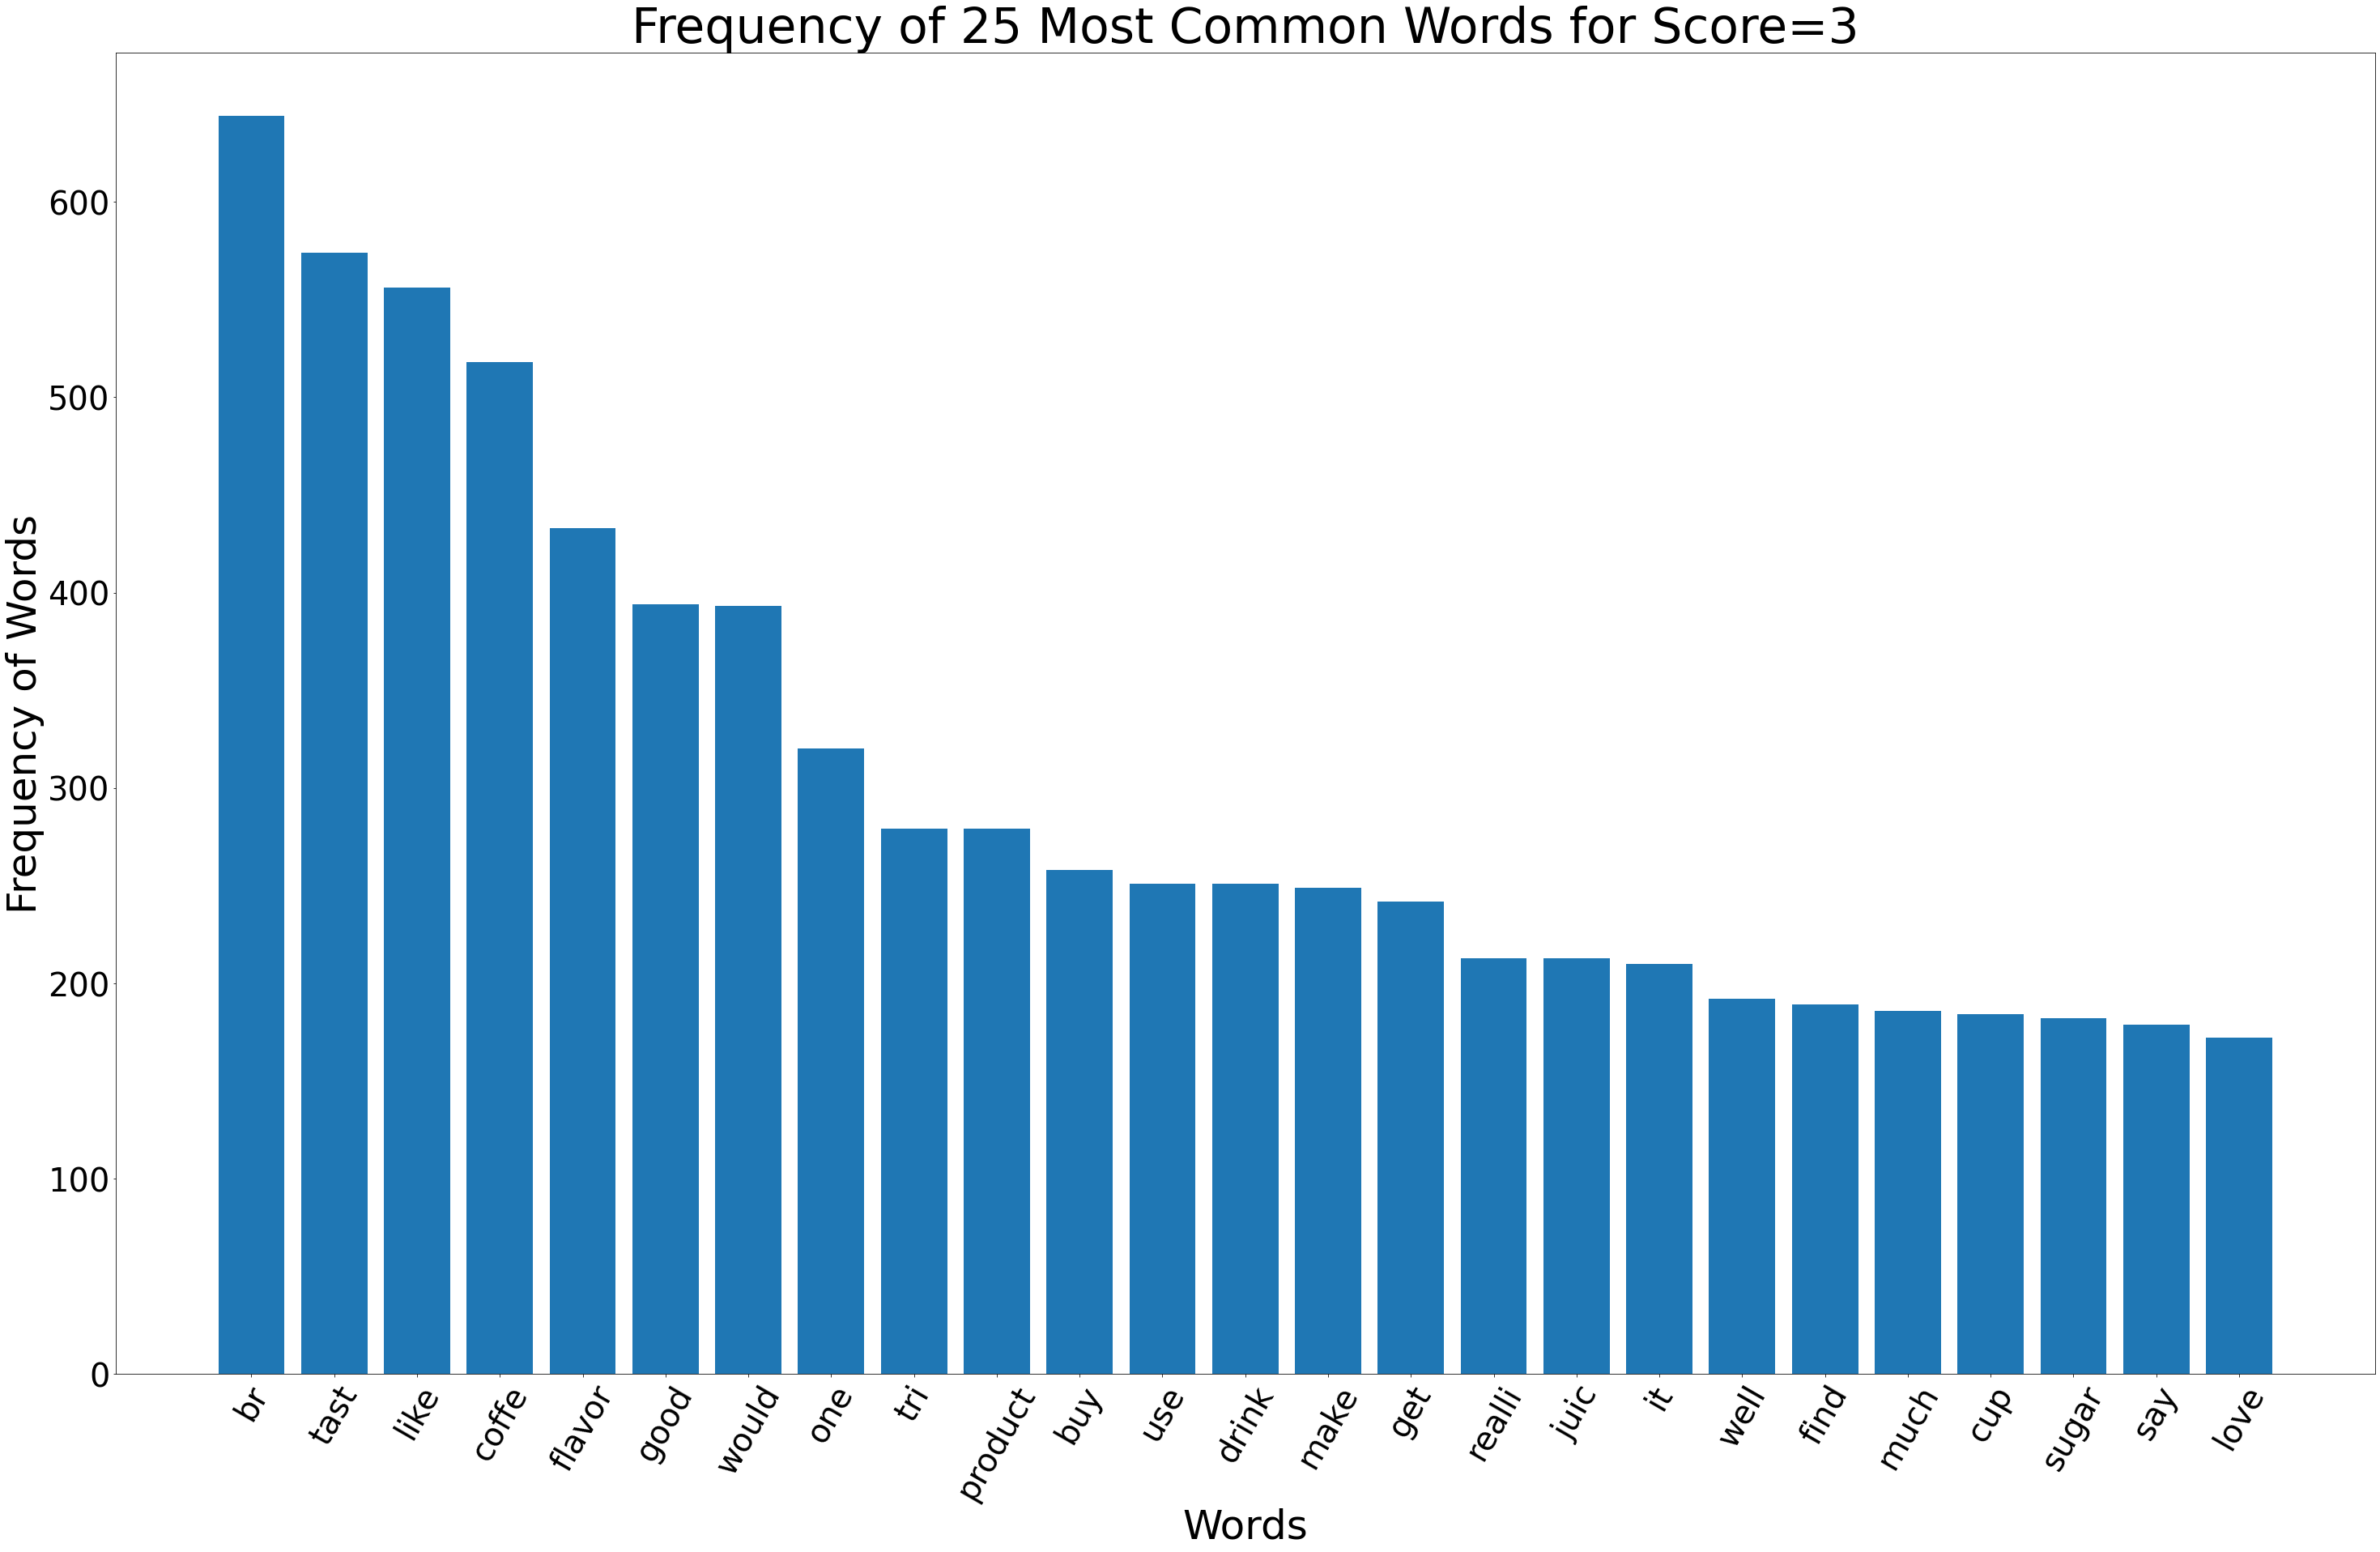

In [29]:
group_by_2 = group_by.iloc[2]
words2 = list(zip(*group_by_2))[0]
freq2 = list(zip(*group_by_2))[1]
plt.figure(figsize=(50,30))
plt.bar(words2, freq2)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Score=3', fontsize=60)
plt.show()

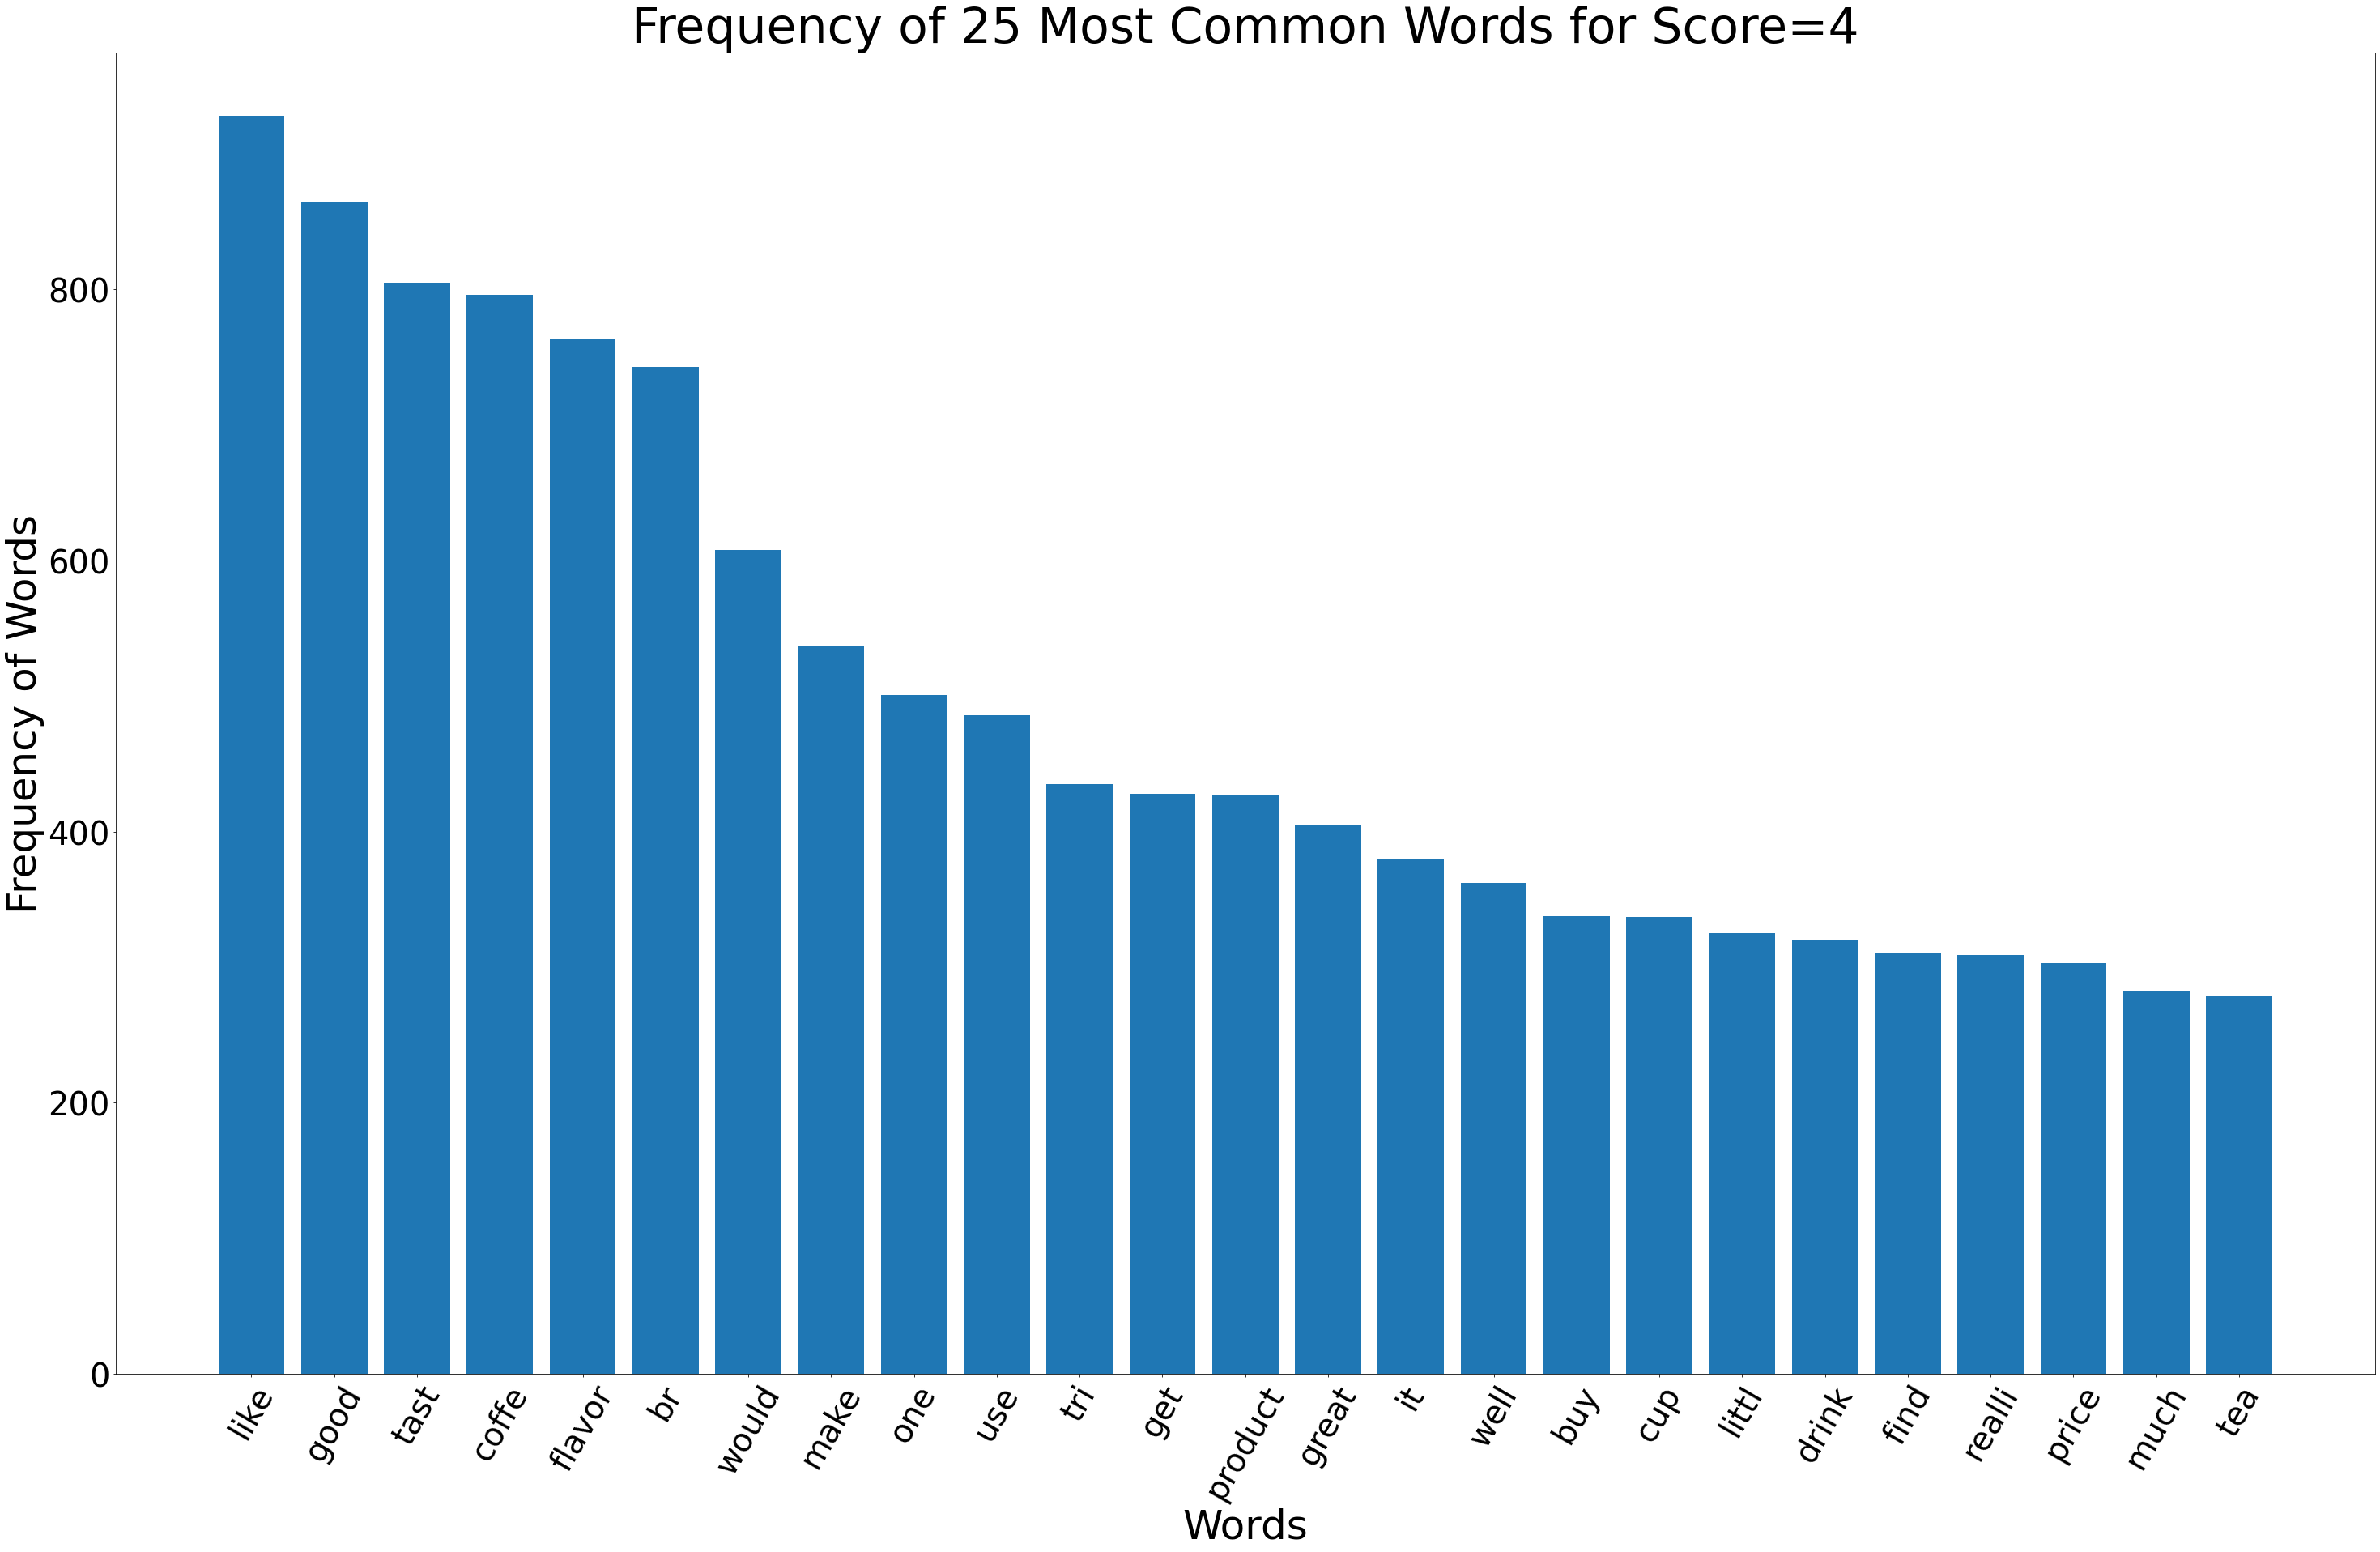

In [30]:
group_by_3 = group_by.iloc[3]
words3 = list(zip(*group_by_3))[0]
freq3 = list(zip(*group_by_3))[1]
plt.figure(figsize=(50,30))
plt.bar(words3, freq3)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Score=4', fontsize=60)
plt.show()

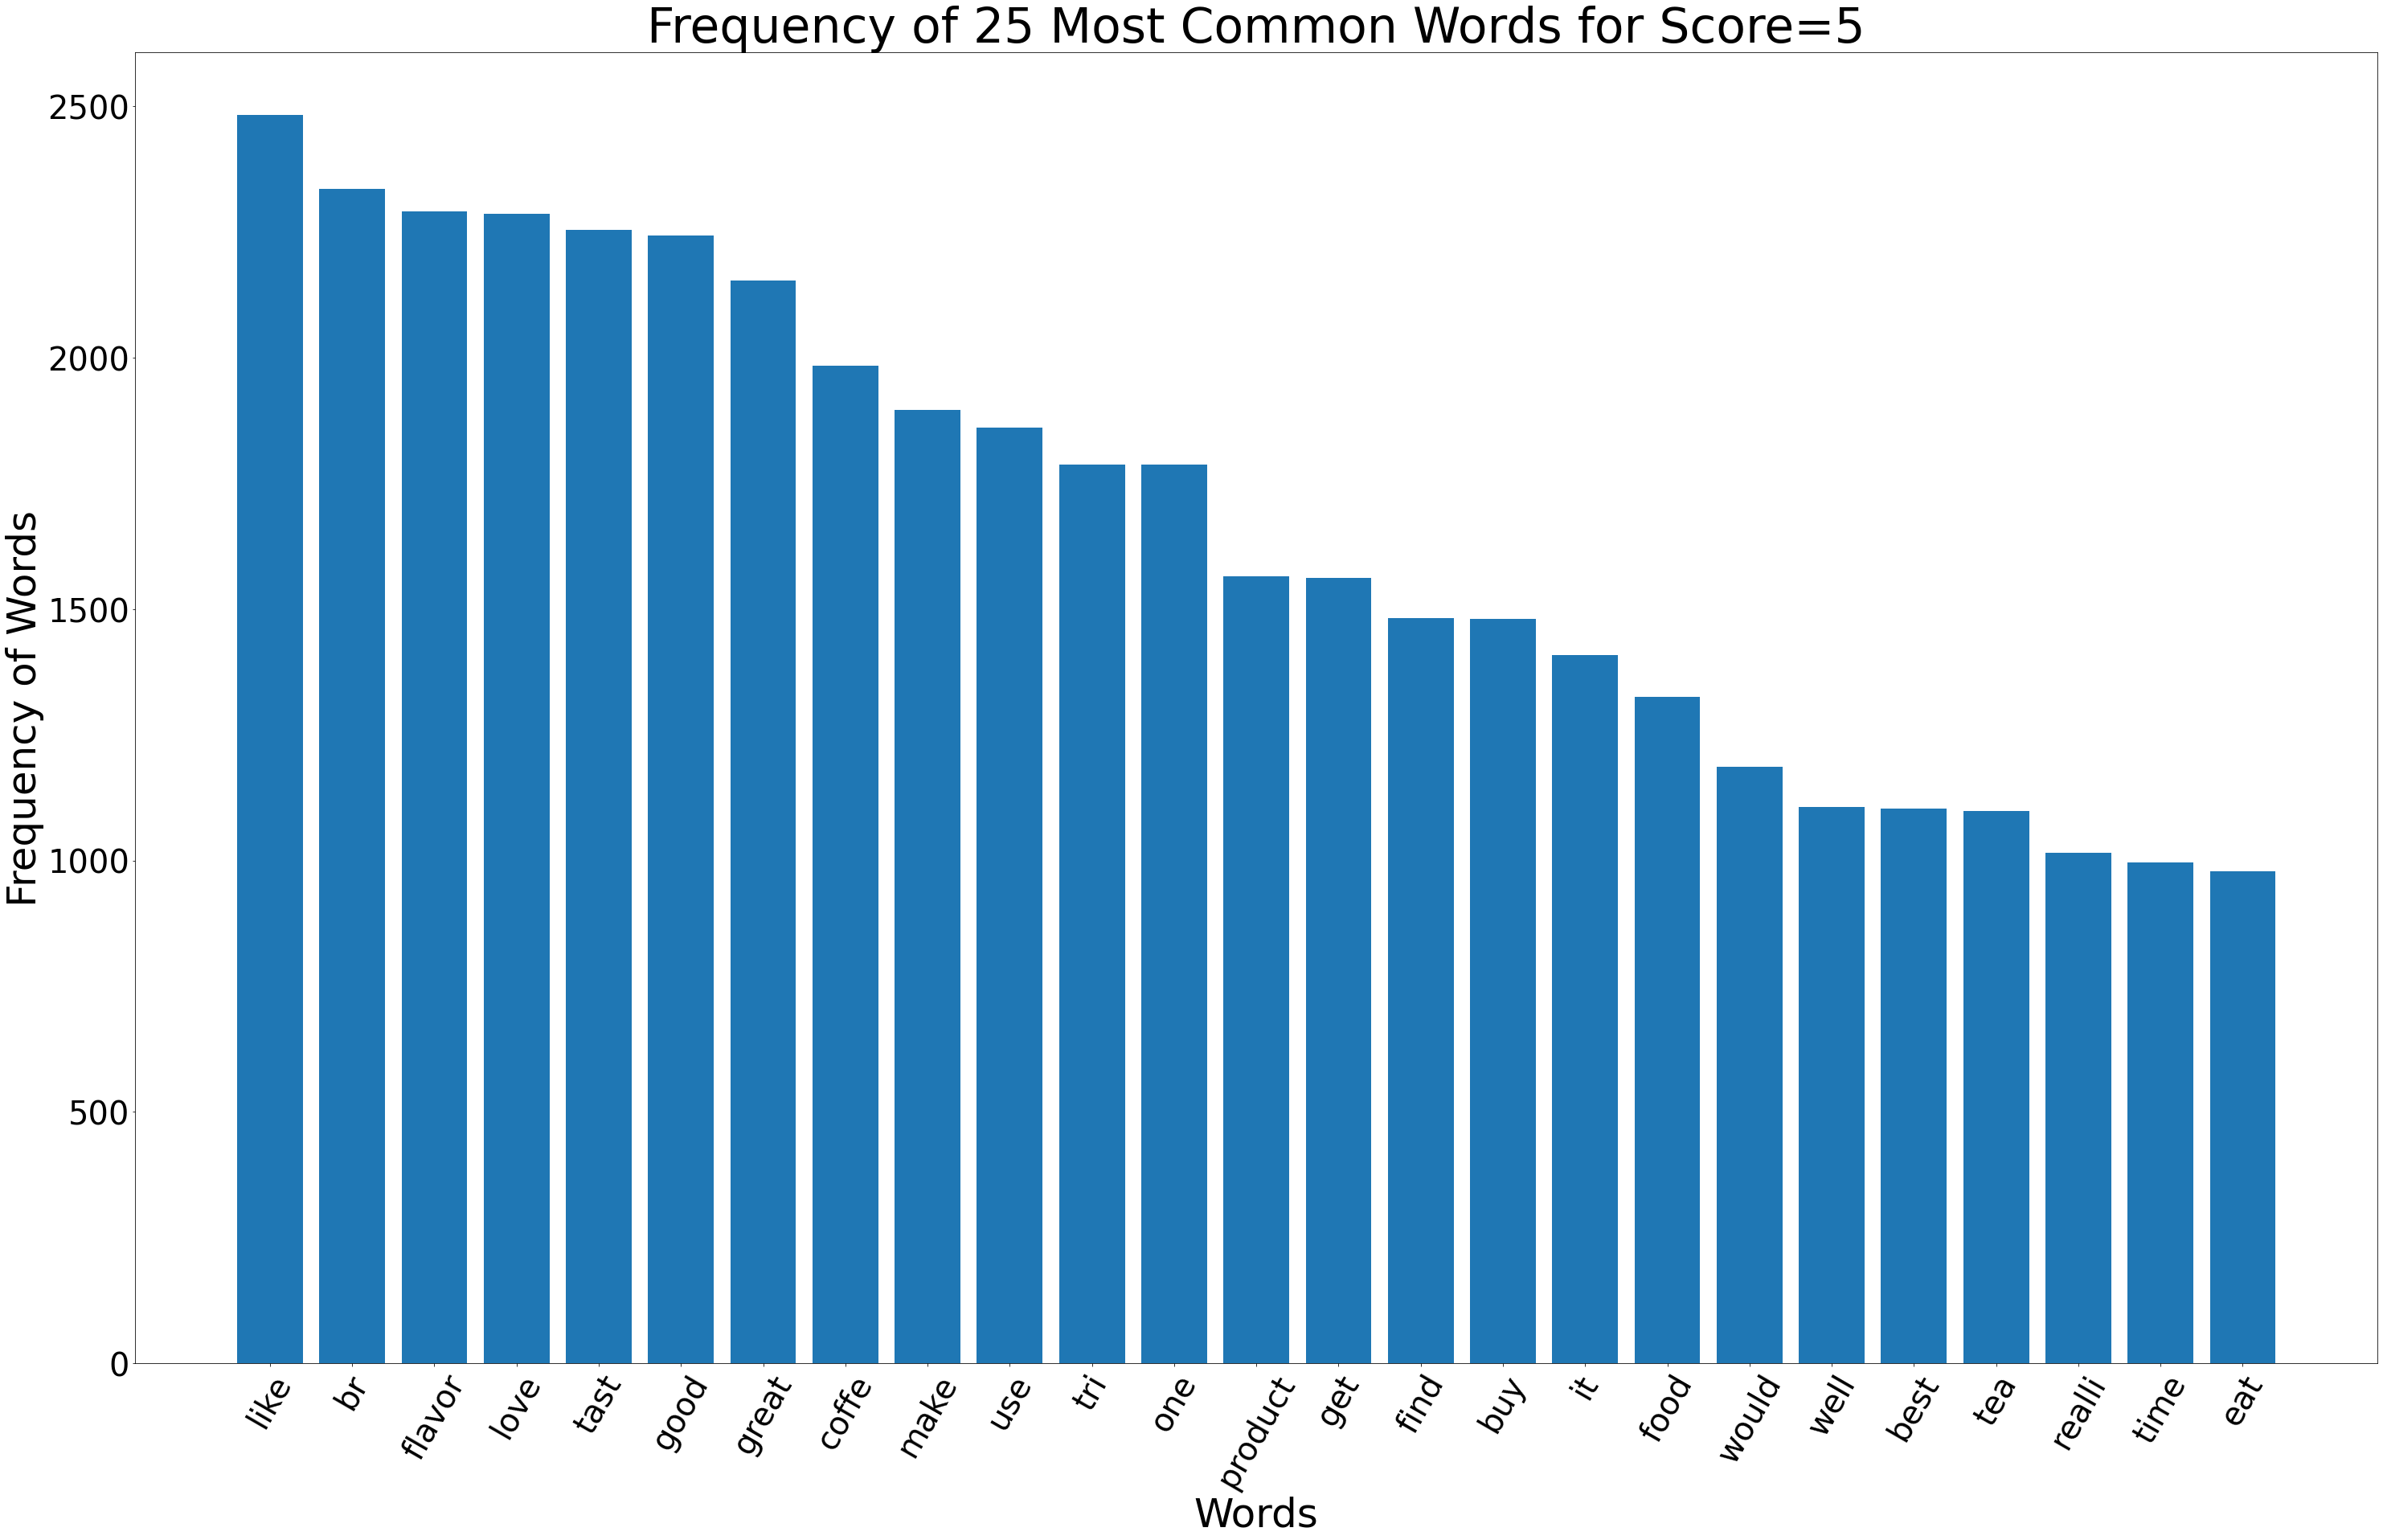

In [31]:
group_by_4 = group_by.iloc[4]
words4 = list(zip(*group_by_4))[0]
freq4 = list(zip(*group_by_4))[1]
plt.figure(figsize=(50,30))
plt.bar(words4, freq4)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Score=5', fontsize=60)
plt.show()

In [32]:
# Klasyfikatory

In [33]:
# print(df_data)

data = df_data

data.shape
data.head()

Score                                          lemma_str
0      5  buy sever vital can dog food product find good...
1      1  product arriv label jumbo salt peanutsth peanu...
2      4  confect around centuri light pillowi citrus ge...
3      2  look secret ingredi robitussin believ find it ...
4      5  great taffi great price wide assort yummi taff...

In [34]:
from sklearn import model_selection, naive_bayes, svm

Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(data['lemma_str'],data['Score'],test_size=0.3)

In [35]:
from sklearn.preprocessing import LabelEncoder

# Encoder = LabelEncoder
# Train_Y = Encoder.fit_transform(Train_Y)
# Test_Y = Encoder.fit_transform(Test_Y)

In [36]:
Tfidf_vect = TfidfVectorizer(max_features=20000)
Tfidf_vect.fit(data['lemma_str'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [37]:
print(Tfidf_vect.vocabulary_)

{'buy': 2353, 'sever': 13743, 'vital': 16834, 'can': 2479, 'dog': 4754, 'food': 6132, 'product': 12221, 'find': 5883, 'good': 6789, 'qualiti': 12450, 'look': 9138, 'like': 8984, 'stew': 14747, 'process': 12206, 'meat': 9560, 'smell': 14158, 'labrador': 8701, 'finicki': 5896, 'appreci': 1018, 'well': 17105, 'most': 10098, 'arriv': 1089, 'label': 8693, 'jumbo': 8439, 'salt': 13358, 'peanutsth': 11469, 'peanut': 11464, 'actual': 430, 'small': 14144, 'size': 14032, 'unsalt': 16492, 'sure': 15120, 'error': 5350, 'vendor': 16713, 'intend': 8116, 'repres': 12912, 'confect': 3538, 'around': 1080, 'centuri': 2740, 'light': 8968, 'pillowi': 11702, 'citrus': 3140, 'gelatin': 6567, 'nut': 10654, 'case': 2643, 'filbert': 5852, 'cut': 4063, 'tini': 15846, 'squar': 14600, 'liber': 8931, 'coat': 3252, 'powder': 12002, 'sugar': 15008, 'mouth': 10126, 'heaven': 7394, 'chewi': 2912, 'flavor': 5975, 'high': 7487, 'recommend': 12698, 'yummi': 17650, 'treat': 16064, 'familiar': 5657, 'stori': 14831, 'lewi':

In [38]:
print(Train_X_Tfidf)

  (0, 16989)	0.21847414102653437
  (0, 16820)	0.2493164534584174
  (0, 16644)	0.15321113095239133
  (0, 15511)	0.20589136560837645
  (0, 15369)	0.06396934226023764
  (0, 12963)	0.1629076371885698
  (0, 12698)	0.0981954427999255
  (0, 12643)	0.13073048277392216
  (0, 12130)	0.18447256950842697
  (0, 11896)	0.18316935774329307
  (0, 11709)	0.22641869036160767
  (0, 10767)	0.14976579013740635
  (0, 10360)	0.19708835994558235
  (0, 9800)	0.2471385313171256
  (0, 9209)	0.1988309019142845
  (0, 9198)	0.1290677751731771
  (0, 8984)	0.062387555828979556
  (0, 8407)	0.2221808061542443
  (0, 7169)	0.13477512212186635
  (0, 6789)	0.13056552196381674
  (0, 3654)	0.13529560422935286
  (0, 3465)	0.237308738237652
  (0, 3350)	0.23136594188828113
  (0, 3281)	0.2816425713207663
  (0, 2605)	0.2818514934324141
  :	:
  (6999, 14892)	0.13444568524147604
  (6999, 13257)	0.16162582136555145
  (6999, 13016)	0.12682632035427688
  (6999, 12698)	0.1148732904343649
  (6999, 11071)	0.1595255100950319
  (6999, 9942

In [39]:
from sklearn.metrics import accuracy_score

# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  61.03333333333333


In [40]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  68.23333333333333


In [41]:
# Bayes i SVM z CountVectorizer

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data.lemma_str)
X_train_counts.shape

(10000, 17724)

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(10000, 17724)

In [44]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, data.Score)

In [45]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB()),])
text_clf = text_clf.fit(data.lemma_str, data.Score)

In [46]:
import numpy as np
data_test = data
predicted = text_clf.predict(data.lemma_str)
np.mean(predicted == data.Score)
# Bayes

0.6184

In [47]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf-svm', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3,random_state=42)),])
_ = text_clf_svm.fit(data.lemma_str, data.Score)
predicted_svm = text_clf_svm.predict(data.lemma_str)
np.mean(predicted_svm == data.Score)

0.6437

In [ ]:
# Random forest

In [72]:
def generate_tokens_freq(tokens):
    dct={}
    for i in tokens:
        dct[i]=0
    for i in tokens:
        dct[i]+=1
    return dct
dct=generate_tokens_freq(df['lemmatized'])
print("Frequency of each tokens = ")
for i in dct.items():
    print(i[0],"\t:" , i[1])

TypeError: unhashable type: 'list'